In [8]:
import pandas as pd
import numpy as np
import joblib
import os

# Loại bỏ sklearn.ensemble vì LSTM không nằm ở đây
# import các thư viện cần cho LSTM từ keras/tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split


In [9]:
pd.set_option('display.max_rows', None)

In [10]:
param_dist = {
    'units': [32, 64, 128],               # số neurons LSTM
    'dropout': [0.2, 0.3, 0.5],          # dropout rate
    'batch_size': [16, 32, 64],           # batch size khi train
    'epochs': [10, 20, 50],               # số epochs
    'learning_rate': [0.001, 0.0005, 0.0001],  # tốc độ học
}


In [11]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def build_lstm_model(input_shape, num_classes, units=64, dropout=0.3):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_phase(phase_path, n_iter=10, random_state=42, sample=False, epochs=30, batch_size=32):
    best_model = None
    best_score = 0
    all_metrics = []
    best_fold = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        # Reshape dữ liệu cho LSTM: (samples, timesteps=1, features)
        X_train_lstm = np.expand_dims(X_train_scaled.values, axis=1)
        X_val_lstm = np.expand_dims(X_val_scaled.values, axis=1)

        # One-hot encode label
        classes = np.unique(np.concatenate((y_train, y_val)))
        num_classes = len(classes)
        y_train_cat = to_categorical(np.searchsorted(classes, y_train), num_classes)
        y_val_cat = to_categorical(np.searchsorted(classes, y_val), num_classes)

        # Xây dựng mô hình LSTM (bạn có thể thay đổi params hoặc thêm vòng loop tuning riêng)
        model = build_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), num_classes=num_classes)

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(
            X_train_lstm, y_train_cat,
            validation_data=(X_val_lstm, y_val_cat),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=2
        )

        # Dự đoán
        y_proba = model.predict(X_val_lstm)
        y_pred = np.argmax(y_proba, axis=1)
        y_true_idx = np.searchsorted(classes, y_val)

        acc = accuracy_score(y_true_idx, y_pred)
        f1 = f1_score(y_true_idx, y_pred, average='macro')

        y_val_bin = label_binarize(y_true_idx, classes=range(num_classes))
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_true_idx, y_pred))

        cm = confusion_matrix(y_true_idx, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Không có feature_importances_ với LSTM, bỏ phần đó

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 15ms/step - accuracy: 0.6338 - loss: 1.0484 - val_accuracy: 0.6630 - val_loss: 0.8642
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6713 - loss: 0.8425 - val_accuracy: 0.6759 - val_loss: 0.8112
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6746 - loss: 0.8056 - val_accuracy: 0.6843 - val_loss: 0.7905
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6822 - loss: 0.7867 - val_accuracy: 0.6906 - val_loss: 0.7815
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6868 - loss: 0.7747 - val_accuracy: 0.6921 - val_loss: 0.7684
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.6876 - loss: 0.7672 - val_accuracy: 0.6917 - val_loss: 0.7593
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.6903 - loss: 0.7598 - val_accuracy: 0.6969 - val_loss: 0.7524
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.6936 - loss: 0.7551 - val_accuracy: 0.6943 - val_loss: 0.7487
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.6961 - loss: 0.7485 - val_accuracy: 0.6969 - val_loss: 0.7460
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


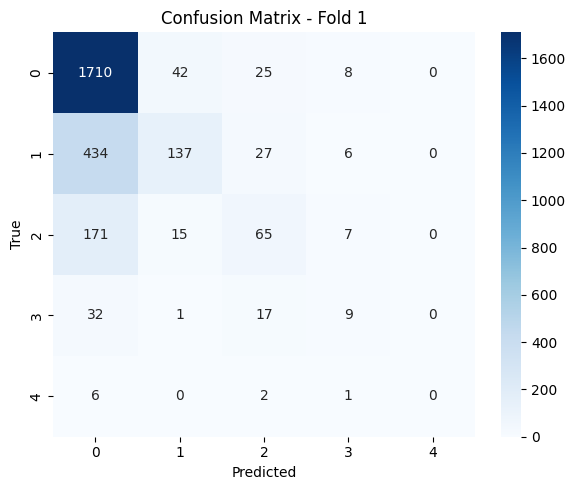

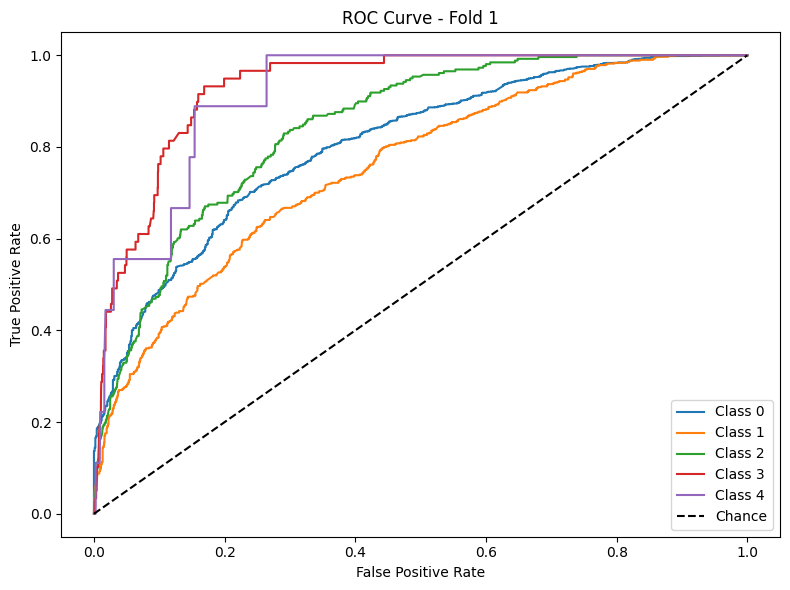

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 4s - 12ms/step - accuracy: 0.6380 - loss: 1.0291 - val_accuracy: 0.6621 - val_loss: 0.8614
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6745 - loss: 0.8330 - val_accuracy: 0.6853 - val_loss: 0.8065
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6818 - loss: 0.8014 - val_accuracy: 0.6842 - val_loss: 0.7885
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6860 - loss: 0.7819 - val_accuracy: 0.6872 - val_loss: 0.7793
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6880 - loss: 0.7750 - val_accuracy: 0.6850 - val_loss: 0.7770
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.6925 - loss: 0.7650 - val_accuracy: 0.6879 - val_loss: 0.7730
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.6937 - loss: 0.7566 - val_accuracy: 0.6912 - val_loss: 0.7610
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.7022 - loss: 0.7436 - val_accuracy: 0.6887 - val_loss: 0.7605
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.7011 - loss: 0.7418 - val_accuracy: 0.6942 - val_loss: 0.7599
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


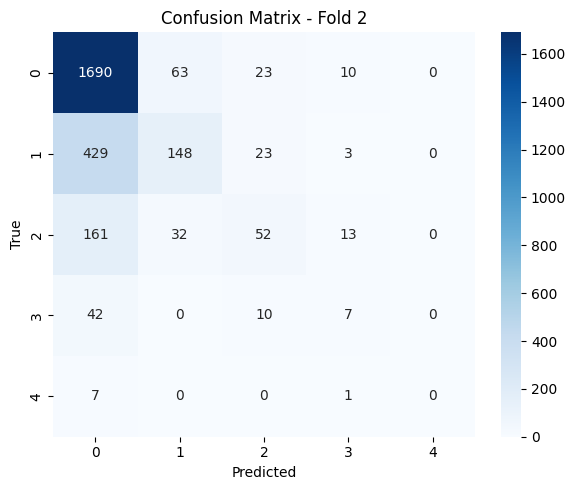

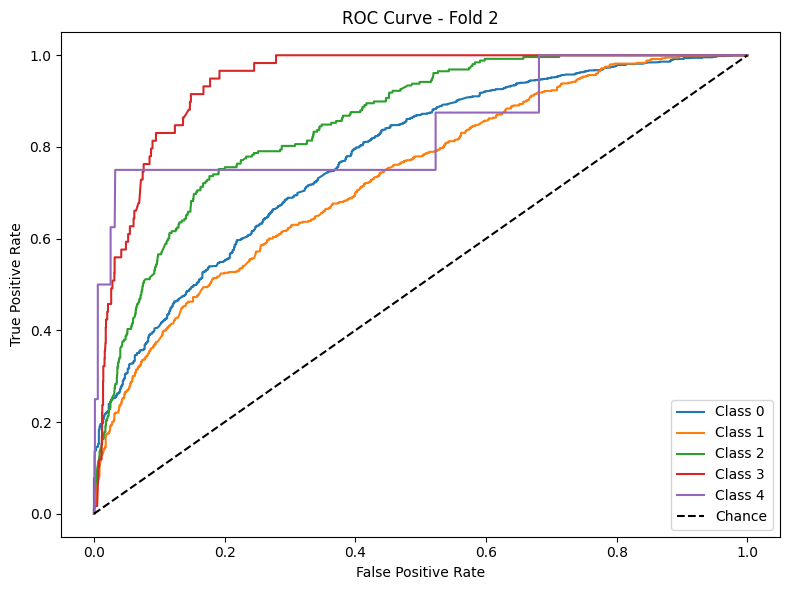

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 4s - 13ms/step - accuracy: 0.6332 - loss: 1.0573 - val_accuracy: 0.6761 - val_loss: 0.8527
Epoch 2/30
340/340 - 1s - 4ms/step - accuracy: 0.6772 - loss: 0.8333 - val_accuracy: 0.6817 - val_loss: 0.7972
Epoch 3/30
340/340 - 1s - 4ms/step - accuracy: 0.6792 - loss: 0.8027 - val_accuracy: 0.6820 - val_loss: 0.7803
Epoch 4/30
340/340 - 1s - 4ms/step - accuracy: 0.6865 - loss: 0.7862 - val_accuracy: 0.6883 - val_loss: 0.7688
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6893 - loss: 0.7719 - val_accuracy: 0.6982 - val_loss: 0.7512
Epoch 6/30
340/340 - 1s - 4ms/step - accuracy: 0.6949 - loss: 0.7618 - val_accuracy: 0.7012 - val_loss: 0.7512
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.6935 - loss: 0.7568 - val_accuracy: 0.6982 - val_loss: 0.7457
Epoch 8/30
340/340 - 1s - 4ms/step - accuracy: 0.6968 - loss: 0.7527 - val_accuracy: 0.6986 - val_loss: 0.7411
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.6998 - loss: 0.7462 - val_accuracy: 0.7001 - val_loss: 0.7406
Epoch 10/30

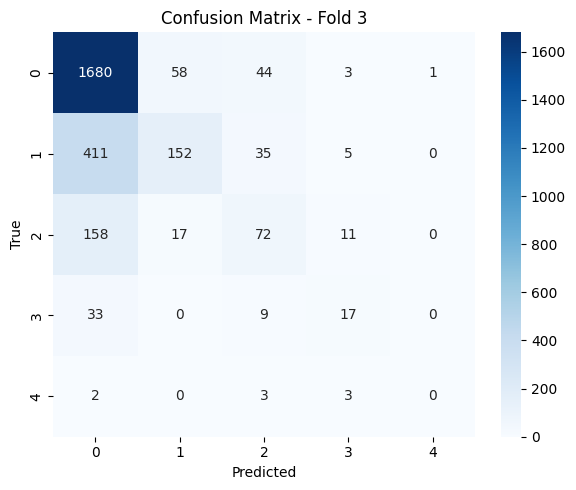

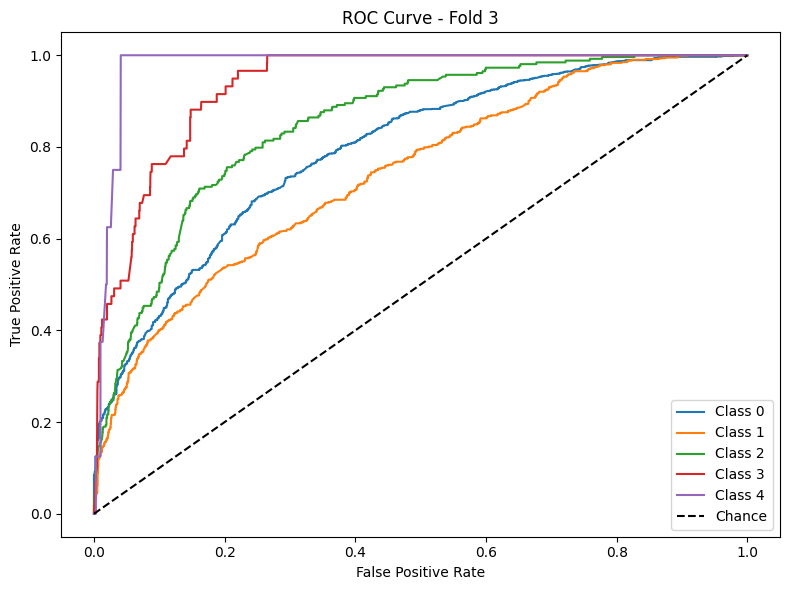

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 5s - 15ms/step - accuracy: 0.6201 - loss: 1.0748 - val_accuracy: 0.6606 - val_loss: 0.8697
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6697 - loss: 0.8397 - val_accuracy: 0.6791 - val_loss: 0.8054
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6757 - loss: 0.8088 - val_accuracy: 0.6942 - val_loss: 0.7785
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6830 - loss: 0.7903 - val_accuracy: 0.6982 - val_loss: 0.7666
Epoch 5/30
340/340 - 1s - 3ms/step - accuracy: 0.6884 - loss: 0.7794 - val_accuracy: 0.6927 - val_loss: 0.7596
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.6894 - loss: 0.7667 - val_accuracy: 0.7067 - val_loss: 0.7480
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.6885 - loss: 0.7642 - val_accuracy: 0.7071 - val_loss: 0.7394
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.6955 - loss: 0.7529 - val_accuracy: 0.7111 - val_loss: 0.7331
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.6983 - loss: 0.7460 - val_accuracy: 0.7137 - val_loss: 0.7279
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


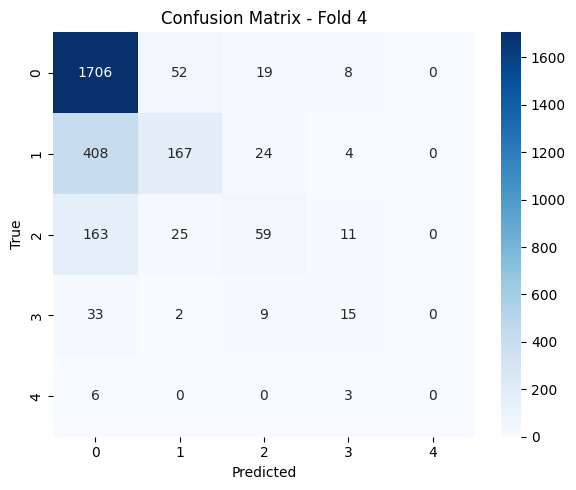

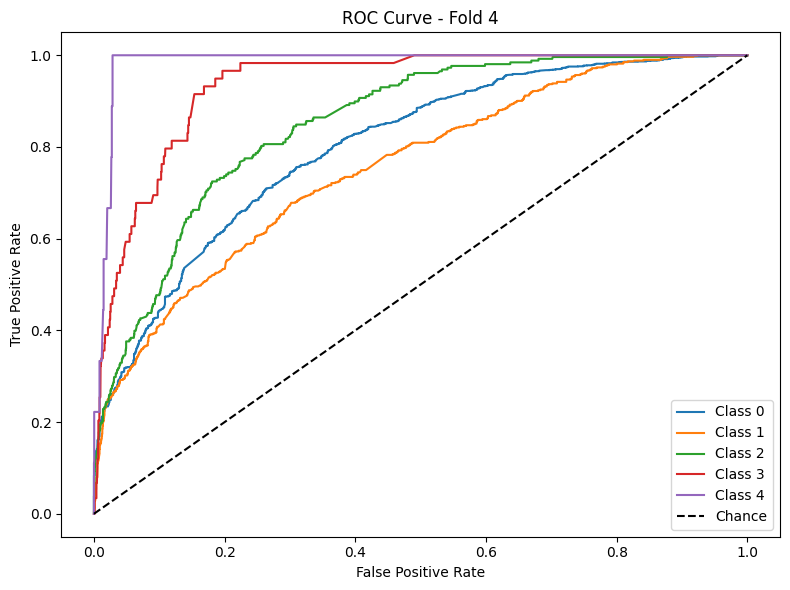

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 4s - 13ms/step - accuracy: 0.6218 - loss: 1.0707 - val_accuracy: 0.6662 - val_loss: 0.8544
Epoch 2/30
340/340 - 1s - 3ms/step - accuracy: 0.6713 - loss: 0.8402 - val_accuracy: 0.6912 - val_loss: 0.7999
Epoch 3/30
340/340 - 1s - 3ms/step - accuracy: 0.6801 - loss: 0.8038 - val_accuracy: 0.6850 - val_loss: 0.7821
Epoch 4/30
340/340 - 1s - 3ms/step - accuracy: 0.6857 - loss: 0.7857 - val_accuracy: 0.6916 - val_loss: 0.7714
Epoch 5/30
340/340 - 1s - 4ms/step - accuracy: 0.6860 - loss: 0.7769 - val_accuracy: 0.6982 - val_loss: 0.7592
Epoch 6/30
340/340 - 1s - 3ms/step - accuracy: 0.6921 - loss: 0.7661 - val_accuracy: 0.6898 - val_loss: 0.7557
Epoch 7/30
340/340 - 1s - 3ms/step - accuracy: 0.6952 - loss: 0.7559 - val_accuracy: 0.6964 - val_loss: 0.7468
Epoch 8/30
340/340 - 1s - 3ms/step - accuracy: 0.6952 - loss: 0.7539 - val_accuracy: 0.6964 - val_loss: 0.7455
Epoch 9/30
340/340 - 1s - 3ms/step - accuracy: 0.6983 - loss: 0.7484 - val_accuracy: 0.7023 - val_loss: 0.7417
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


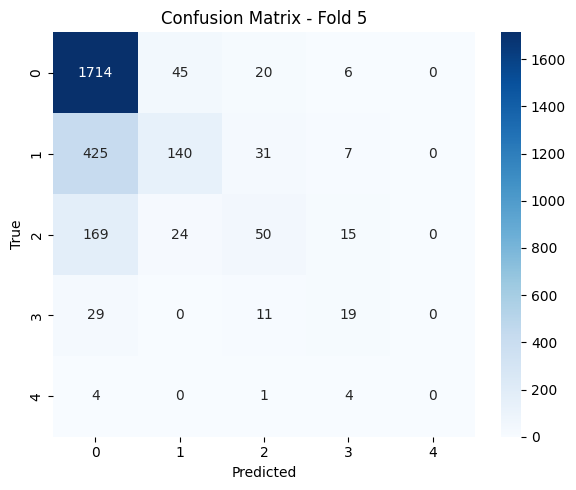

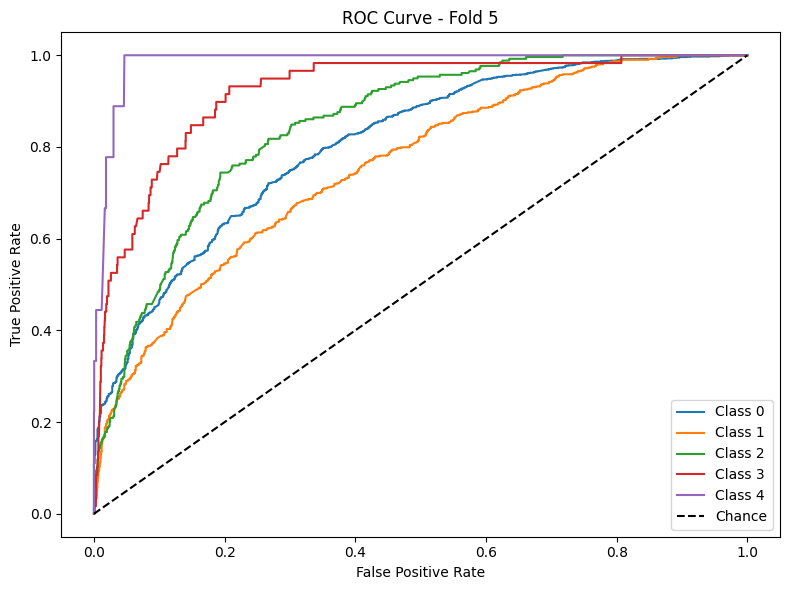


Average Accuracy: 0.7081
Average F1 Macro: 0.3529
Average AUC: 0.8538


======= Training Phase 2 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 15ms/step - accuracy: 0.6187 - loss: 1.0903 - val_accuracy: 0.6602 - val_loss: 0.8952
Epoch 2/30
283/283 - 1s - 4ms/step - accuracy: 0.6687 - loss: 0.8559 - val_accuracy: 0.6752 - val_loss: 0.8314
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6759 - loss: 0.8143 - val_accuracy: 0.6774 - val_loss: 0.8067
Epoch 4/30
283/283 - 1s - 4ms/step - accuracy: 0.6823 - loss: 0.7973 - val_accuracy: 0.6801 - val_loss: 0.7904
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6820 - loss: 0.7826 - val_accuracy: 0.6801 - val_loss: 0.7797
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6876 - loss: 0.7741 - val_accuracy: 0.6876 - val_loss: 0.7754
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6881 - loss: 0.7656 - val_accuracy: 0.6889 - val_loss: 0.7674
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6906 - loss: 0.7566 - val_accuracy: 0.6863 - val_loss: 0.7679
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.6918 - loss: 0.7553 - val_accuracy: 0.6920 - val_loss: 0.7629
Epoch 10/30

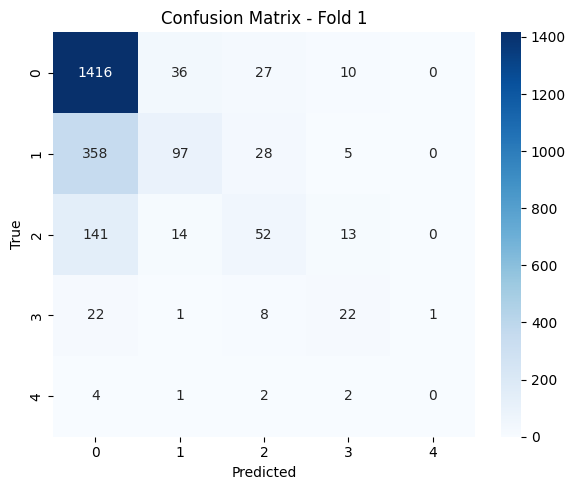

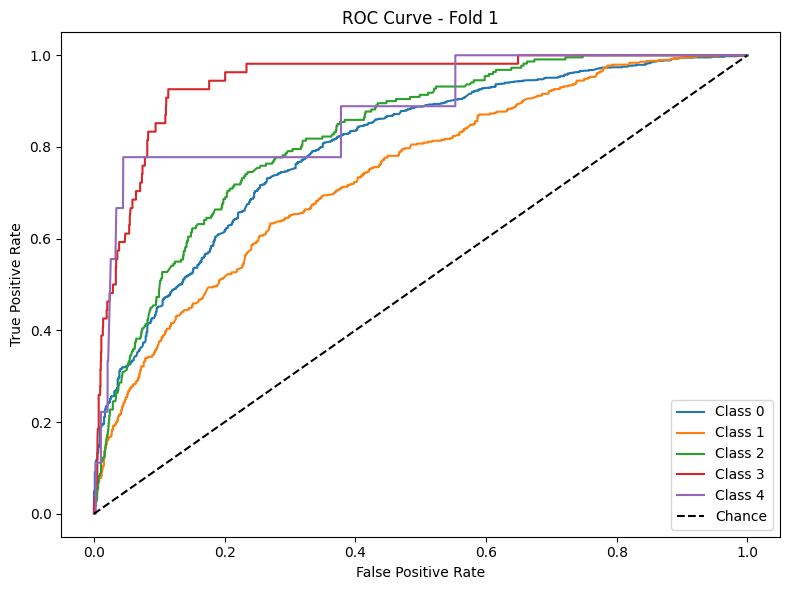

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 5s - 18ms/step - accuracy: 0.6271 - loss: 1.0831 - val_accuracy: 0.6642 - val_loss: 0.8713
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6665 - loss: 0.8574 - val_accuracy: 0.6801 - val_loss: 0.8078
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6754 - loss: 0.8158 - val_accuracy: 0.6907 - val_loss: 0.7873
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6824 - loss: 0.7964 - val_accuracy: 0.6858 - val_loss: 0.7730
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6854 - loss: 0.7839 - val_accuracy: 0.6889 - val_loss: 0.7661
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6850 - loss: 0.7725 - val_accuracy: 0.6898 - val_loss: 0.7606
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6910 - loss: 0.7650 - val_accuracy: 0.6916 - val_loss: 0.7545
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6905 - loss: 0.7573 - val_accuracy: 0.7013 - val_loss: 0.7488
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.6937 - loss: 0.7522 - val_accuracy: 0.6969 - val_loss: 0.7524
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


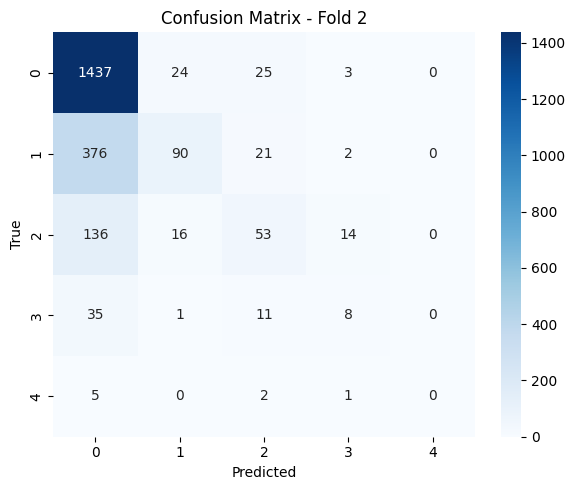

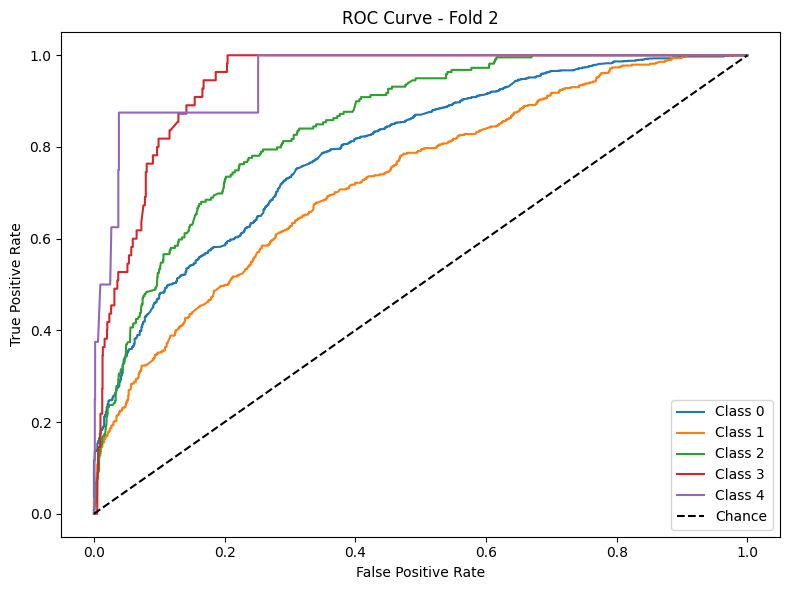

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 14ms/step - accuracy: 0.6178 - loss: 1.0890 - val_accuracy: 0.6618 - val_loss: 0.8888
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6680 - loss: 0.8519 - val_accuracy: 0.6777 - val_loss: 0.8273
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6790 - loss: 0.8117 - val_accuracy: 0.6760 - val_loss: 0.8099
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6829 - loss: 0.7934 - val_accuracy: 0.6804 - val_loss: 0.7938
Epoch 5/30
283/283 - 1s - 4ms/step - accuracy: 0.6850 - loss: 0.7818 - val_accuracy: 0.6755 - val_loss: 0.7888
Epoch 6/30
283/283 - 1s - 3ms/step - accuracy: 0.6870 - loss: 0.7745 - val_accuracy: 0.6764 - val_loss: 0.7848
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6925 - loss: 0.7633 - val_accuracy: 0.6835 - val_loss: 0.7789
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6903 - loss: 0.7607 - val_accuracy: 0.6861 - val_loss: 0.7724
Epoch 9/30
283/283 - 1s - 4ms/step - accuracy: 0.6946 - loss: 0.7524 - val_accuracy: 0.6870 - val_loss: 0.7635
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


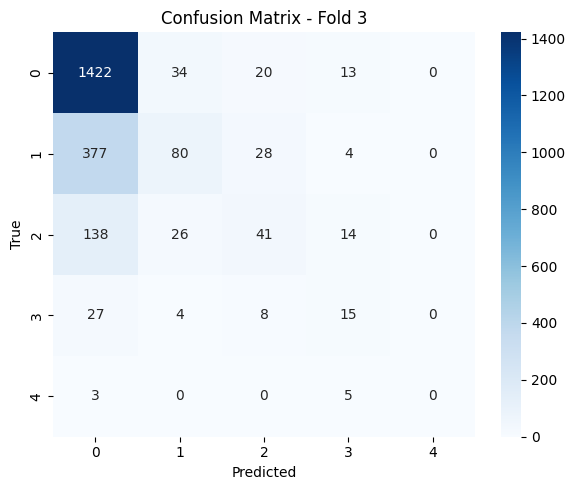

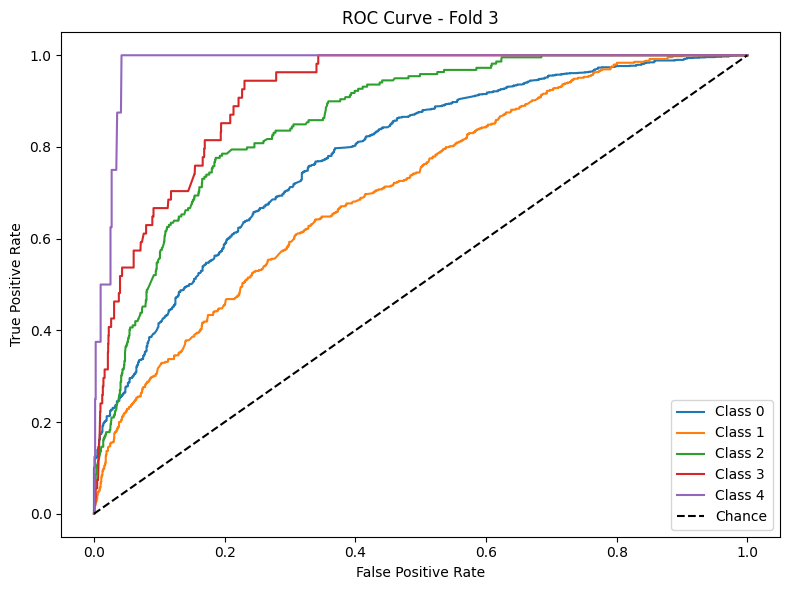

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 14ms/step - accuracy: 0.6271 - loss: 1.0870 - val_accuracy: 0.6600 - val_loss: 0.8853
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6645 - loss: 0.8575 - val_accuracy: 0.6742 - val_loss: 0.8226
Epoch 3/30
283/283 - 1s - 3ms/step - accuracy: 0.6743 - loss: 0.8190 - val_accuracy: 0.6804 - val_loss: 0.7952
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6792 - loss: 0.7997 - val_accuracy: 0.6729 - val_loss: 0.7837
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6812 - loss: 0.7825 - val_accuracy: 0.6861 - val_loss: 0.7746
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6840 - loss: 0.7754 - val_accuracy: 0.6853 - val_loss: 0.7668
Epoch 7/30
283/283 - 1s - 3ms/step - accuracy: 0.6879 - loss: 0.7692 - val_accuracy: 0.6897 - val_loss: 0.7615
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6883 - loss: 0.7594 - val_accuracy: 0.6963 - val_loss: 0.7598
Epoch 9/30
283/283 - 1s - 3ms/step - accuracy: 0.6933 - loss: 0.7524 - val_accuracy: 0.6963 - val_loss: 0.7595
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


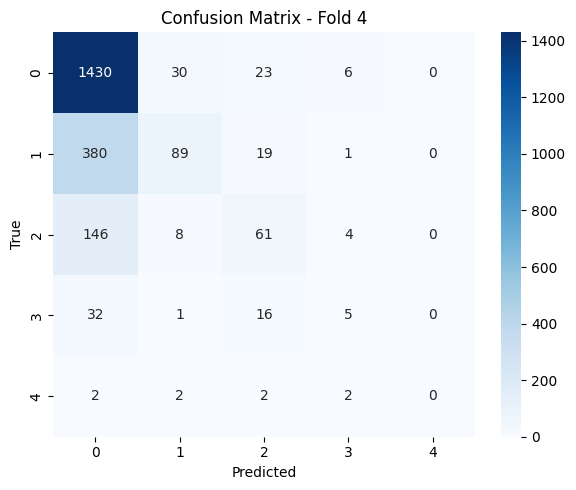

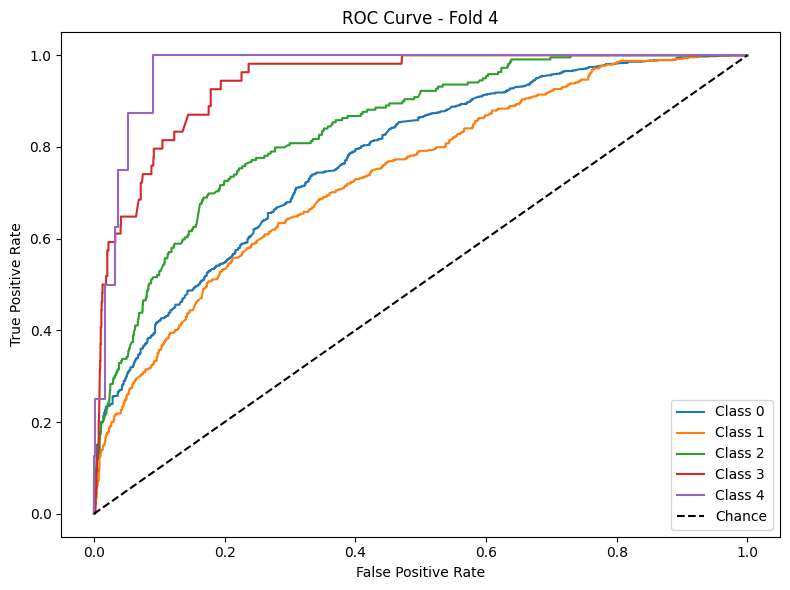

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 - 4s - 14ms/step - accuracy: 0.6326 - loss: 1.0691 - val_accuracy: 0.6618 - val_loss: 0.8715
Epoch 2/30
283/283 - 1s - 3ms/step - accuracy: 0.6683 - loss: 0.8586 - val_accuracy: 0.6777 - val_loss: 0.8190
Epoch 3/30
283/283 - 1s - 4ms/step - accuracy: 0.6749 - loss: 0.8147 - val_accuracy: 0.6861 - val_loss: 0.7971
Epoch 4/30
283/283 - 1s - 3ms/step - accuracy: 0.6763 - loss: 0.8001 - val_accuracy: 0.6879 - val_loss: 0.7851
Epoch 5/30
283/283 - 1s - 3ms/step - accuracy: 0.6839 - loss: 0.7855 - val_accuracy: 0.6906 - val_loss: 0.7712
Epoch 6/30
283/283 - 1s - 4ms/step - accuracy: 0.6832 - loss: 0.7791 - val_accuracy: 0.6884 - val_loss: 0.7668
Epoch 7/30
283/283 - 1s - 4ms/step - accuracy: 0.6878 - loss: 0.7688 - val_accuracy: 0.6950 - val_loss: 0.7652
Epoch 8/30
283/283 - 1s - 3ms/step - accuracy: 0.6916 - loss: 0.7626 - val_accuracy: 0.6977 - val_loss: 0.7578
Epoch 9/30
283/283 - 1s - 4ms/step - accuracy: 0.6936 - loss: 0.7532 - val_accuracy: 0.6968 - val_loss: 0.7586
Epoch 10/30

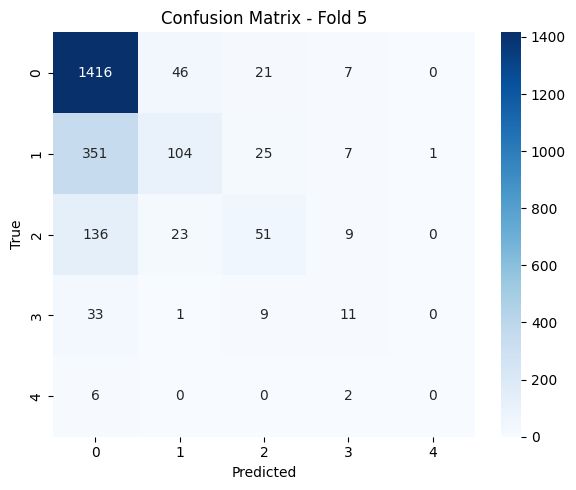

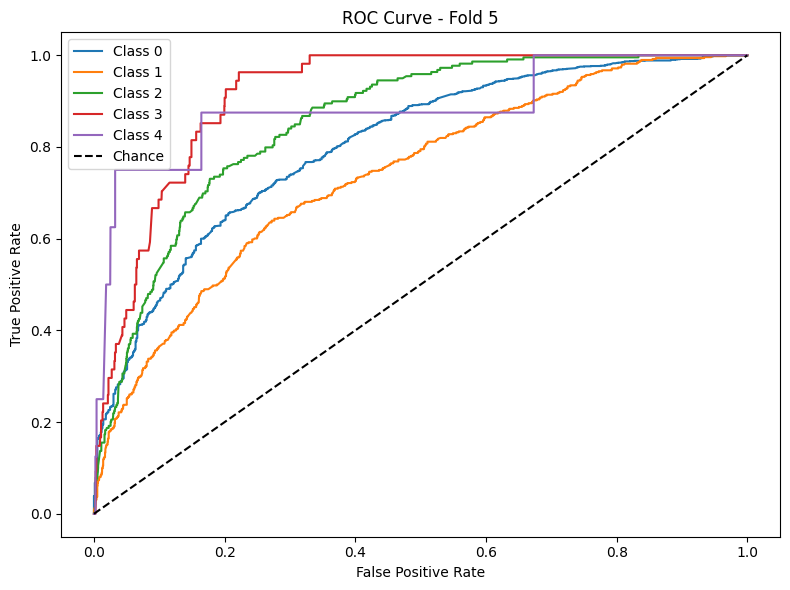


Average Accuracy: 0.6993
Average F1 Macro: 0.3364
Average AUC: 0.8464


======= Training Phase 3 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
260/260 - 4s - 16ms/step - accuracy: 0.6088 - loss: 1.0951 - val_accuracy: 0.6649 - val_loss: 0.8902
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6631 - loss: 0.8605 - val_accuracy: 0.6770 - val_loss: 0.8246
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6706 - loss: 0.8207 - val_accuracy: 0.6866 - val_loss: 0.8007
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6731 - loss: 0.7974 - val_accuracy: 0.6871 - val_loss: 0.7799
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6821 - loss: 0.7861 - val_accuracy: 0.6895 - val_loss: 0.7702
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6831 - loss: 0.7754 - val_accuracy: 0.6929 - val_loss: 0.7587
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6872 - loss: 0.7647 - val_accuracy: 0.6895 - val_loss: 0.7619
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6882 - loss: 0.7608 - val_accuracy: 0.6909 - val_loss: 0.7530
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6937 - loss: 0.7523 - val_accuracy: 0.6948 - val_loss: 0.7519


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


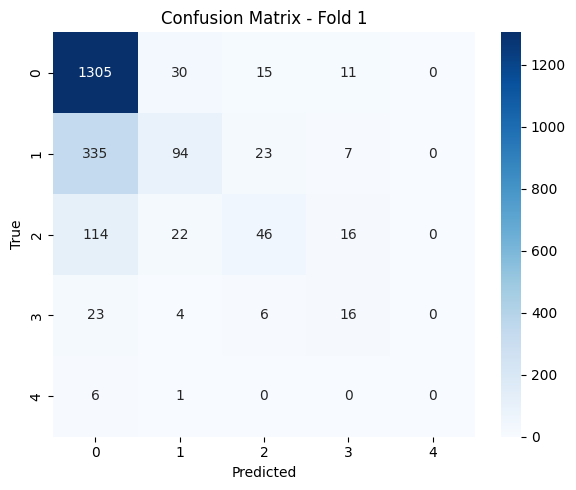

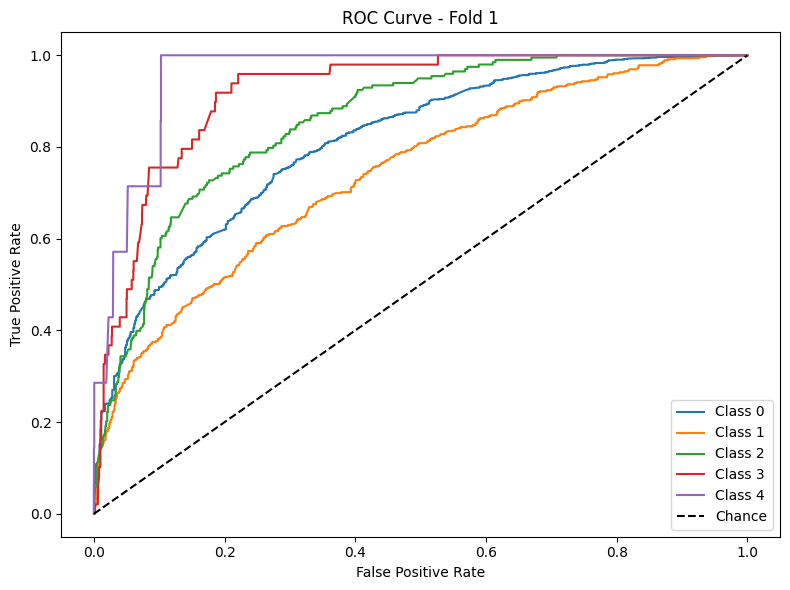

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 5s - 17ms/step - accuracy: 0.6189 - loss: 1.1094 - val_accuracy: 0.6562 - val_loss: 0.8842
Epoch 2/30
260/260 - 1s - 5ms/step - accuracy: 0.6649 - loss: 0.8608 - val_accuracy: 0.6736 - val_loss: 0.8166
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6735 - loss: 0.8188 - val_accuracy: 0.6818 - val_loss: 0.7944
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6797 - loss: 0.7960 - val_accuracy: 0.6798 - val_loss: 0.7816
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6846 - loss: 0.7798 - val_accuracy: 0.6842 - val_loss: 0.7794
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6845 - loss: 0.7704 - val_accuracy: 0.6900 - val_loss: 0.7686
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6887 - loss: 0.7569 - val_accuracy: 0.6880 - val_loss: 0.7723
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6892 - loss: 0.7551 - val_accuracy: 0.6958 - val_loss: 0.7587
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6891 - loss: 0.7549 - val_accuracy: 0.6977 - val_loss: 0.7536
Epoch 10/30

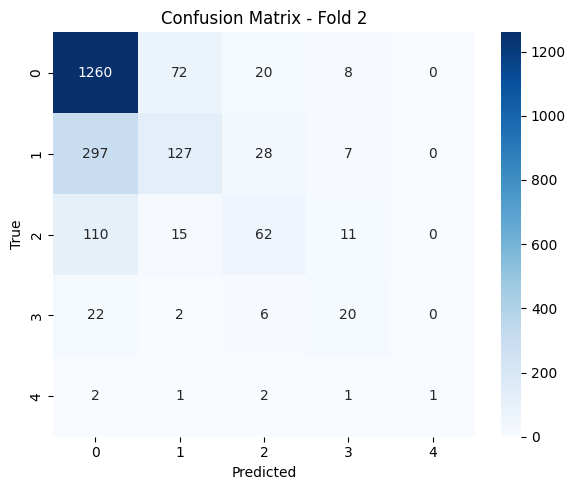

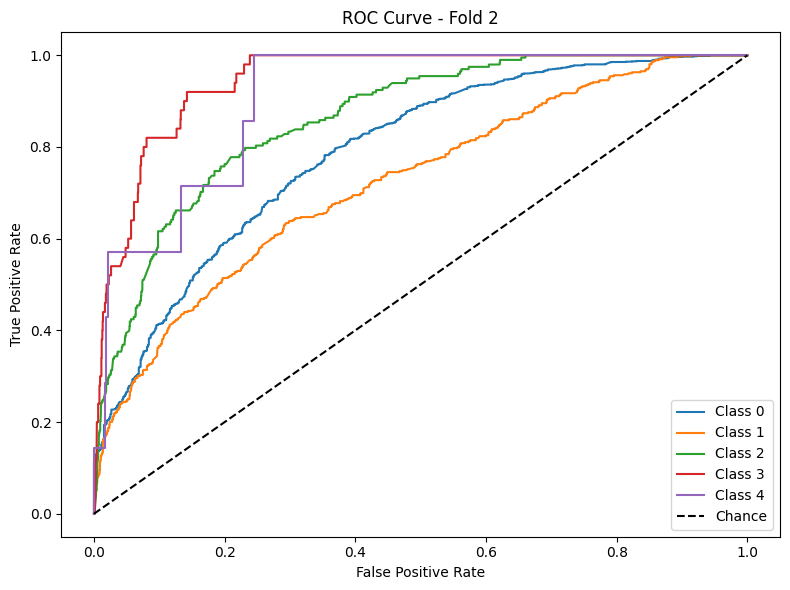

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 16ms/step - accuracy: 0.6071 - loss: 1.1240 - val_accuracy: 0.6601 - val_loss: 0.8914
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6646 - loss: 0.8609 - val_accuracy: 0.6750 - val_loss: 0.8236
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6731 - loss: 0.8189 - val_accuracy: 0.6808 - val_loss: 0.7983
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6770 - loss: 0.7969 - val_accuracy: 0.6847 - val_loss: 0.7831
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6804 - loss: 0.7812 - val_accuracy: 0.6866 - val_loss: 0.7725
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6872 - loss: 0.7712 - val_accuracy: 0.6885 - val_loss: 0.7632
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6899 - loss: 0.7646 - val_accuracy: 0.6953 - val_loss: 0.7584
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6887 - loss: 0.7578 - val_accuracy: 0.6871 - val_loss: 0.7589
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6917 - loss: 0.7436 - val_accuracy: 0.6958 - val_loss: 0.7567
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


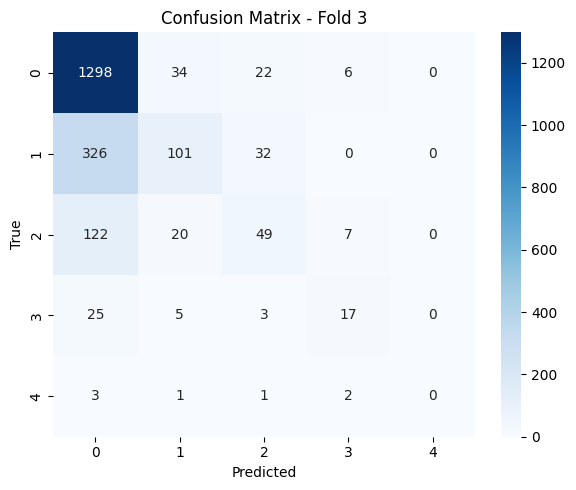

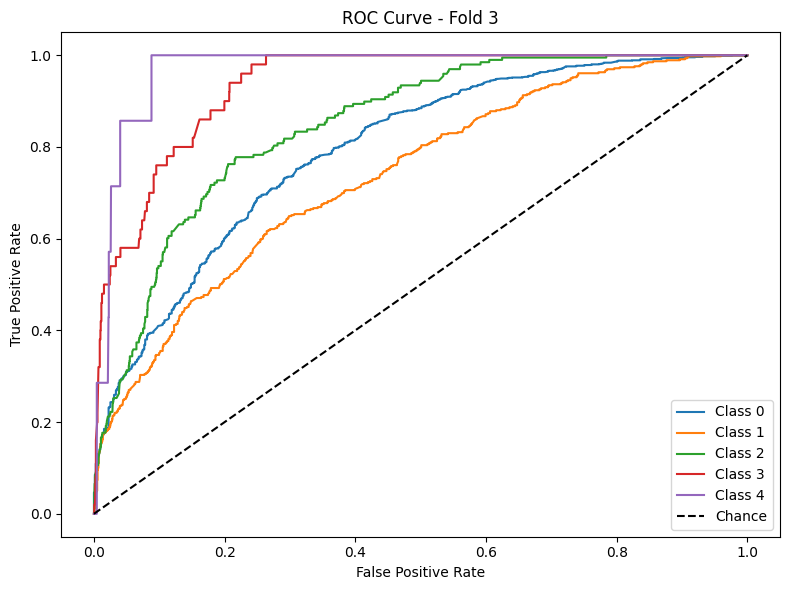

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 6s - 22ms/step - accuracy: 0.6210 - loss: 1.0969 - val_accuracy: 0.6562 - val_loss: 0.8961
Epoch 2/30
260/260 - 1s - 3ms/step - accuracy: 0.6693 - loss: 0.8573 - val_accuracy: 0.6750 - val_loss: 0.8275
Epoch 3/30
260/260 - 1s - 3ms/step - accuracy: 0.6762 - loss: 0.8133 - val_accuracy: 0.6741 - val_loss: 0.8057
Epoch 4/30
260/260 - 1s - 3ms/step - accuracy: 0.6782 - loss: 0.7906 - val_accuracy: 0.6794 - val_loss: 0.7950
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6814 - loss: 0.7795 - val_accuracy: 0.6760 - val_loss: 0.7849
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6826 - loss: 0.7711 - val_accuracy: 0.6774 - val_loss: 0.7773
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6845 - loss: 0.7610 - val_accuracy: 0.6837 - val_loss: 0.7714
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6887 - loss: 0.7554 - val_accuracy: 0.6880 - val_loss: 0.7678
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6888 - loss: 0.7477 - val_accuracy: 0.6871 - val_loss: 0.7627
Epoch 10/30

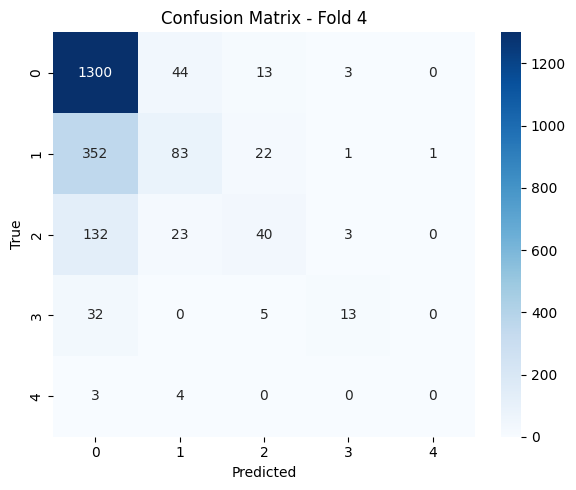

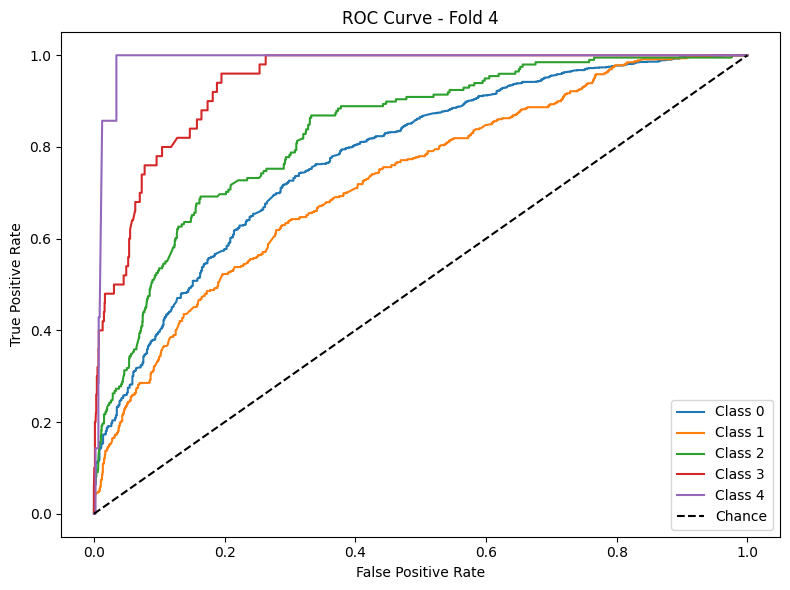

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 - 4s - 17ms/step - accuracy: 0.6126 - loss: 1.1113 - val_accuracy: 0.6532 - val_loss: 0.8955
Epoch 2/30
260/260 - 1s - 4ms/step - accuracy: 0.6631 - loss: 0.8583 - val_accuracy: 0.6633 - val_loss: 0.8327
Epoch 3/30
260/260 - 1s - 4ms/step - accuracy: 0.6736 - loss: 0.8131 - val_accuracy: 0.6676 - val_loss: 0.8058
Epoch 4/30
260/260 - 1s - 4ms/step - accuracy: 0.6831 - loss: 0.7845 - val_accuracy: 0.6705 - val_loss: 0.8030
Epoch 5/30
260/260 - 1s - 4ms/step - accuracy: 0.6878 - loss: 0.7762 - val_accuracy: 0.6729 - val_loss: 0.7906
Epoch 6/30
260/260 - 1s - 4ms/step - accuracy: 0.6915 - loss: 0.7590 - val_accuracy: 0.6768 - val_loss: 0.7843
Epoch 7/30
260/260 - 1s - 4ms/step - accuracy: 0.6930 - loss: 0.7563 - val_accuracy: 0.6826 - val_loss: 0.7789
Epoch 8/30
260/260 - 1s - 4ms/step - accuracy: 0.6942 - loss: 0.7500 - val_accuracy: 0.6840 - val_loss: 0.7752
Epoch 9/30
260/260 - 1s - 4ms/step - accuracy: 0.6980 - loss: 0.7409 - val_accuracy: 0.6807 - val_loss: 0.7758
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


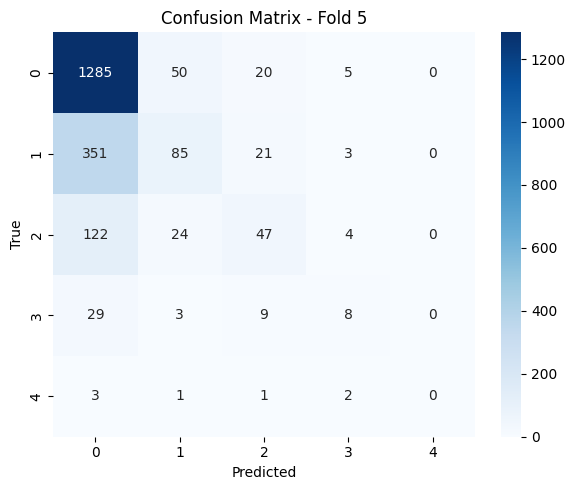

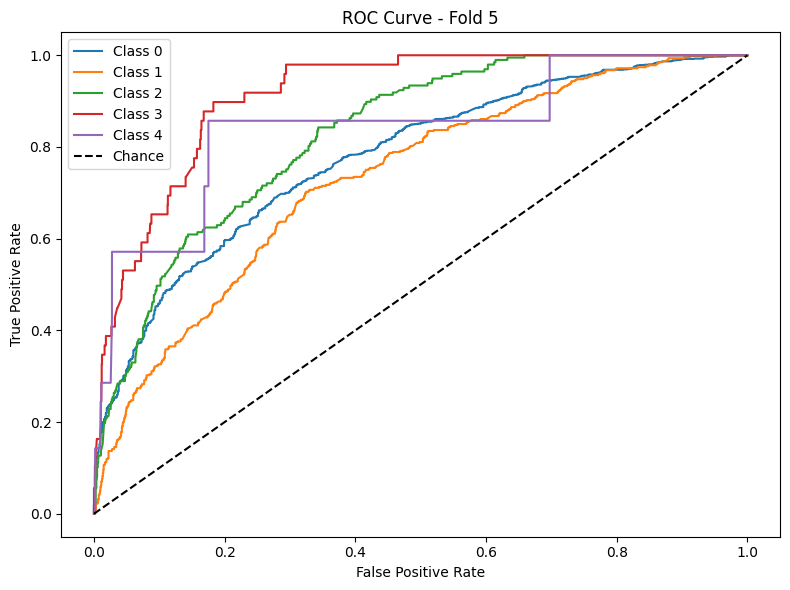


Average Accuracy: 0.6999
Average F1 Macro: 0.3723
Average AUC: 0.8460


======= Training Phase 4 ========

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 22ms/step - accuracy: 0.5985 - loss: 1.1718 - val_accuracy: 0.6621 - val_loss: 0.9380
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6685 - loss: 0.8864 - val_accuracy: 0.6667 - val_loss: 0.8430
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6776 - loss: 0.8214 - val_accuracy: 0.6732 - val_loss: 0.8066
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6857 - loss: 0.7905 - val_accuracy: 0.6693 - val_loss: 0.7936
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6830 - loss: 0.7774 - val_accuracy: 0.6719 - val_loss: 0.7865
Epoch 6/30
193/193 - 1s - 5ms/step - accuracy: 0.6919 - loss: 0.7572 - val_accuracy: 0.6797 - val_loss: 0.7724
Epoch 7/30
193/193 - 1s - 5ms/step - accuracy: 0.6945 - loss: 0.7457 - val_accuracy: 0.6816 - val_loss: 0.7684
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.7000 - loss: 0.7364 - val_accuracy: 0.6907 - val_loss: 0.7622
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.7015 - loss: 0.7312 - val_accuracy: 0.6894 - val_loss: 0.7591
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


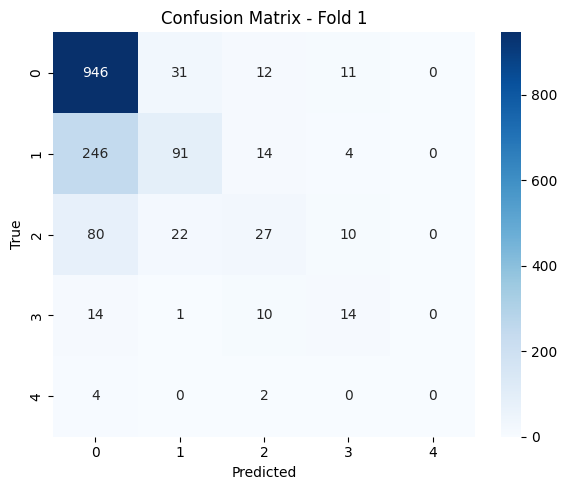

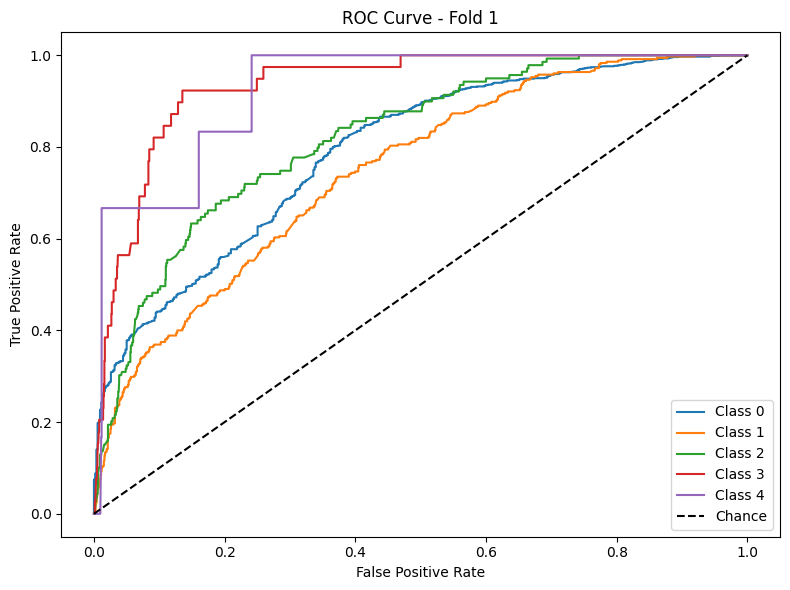

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 23ms/step - accuracy: 0.5860 - loss: 1.1951 - val_accuracy: 0.6654 - val_loss: 0.9466
Epoch 2/30
193/193 - 1s - 5ms/step - accuracy: 0.6625 - loss: 0.8887 - val_accuracy: 0.6712 - val_loss: 0.8432
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6765 - loss: 0.8238 - val_accuracy: 0.6738 - val_loss: 0.8088
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6752 - loss: 0.7967 - val_accuracy: 0.6777 - val_loss: 0.7926
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6861 - loss: 0.7769 - val_accuracy: 0.6803 - val_loss: 0.7829
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6895 - loss: 0.7621 - val_accuracy: 0.6680 - val_loss: 0.7761
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6908 - loss: 0.7473 - val_accuracy: 0.6751 - val_loss: 0.7627
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6950 - loss: 0.7378 - val_accuracy: 0.6784 - val_loss: 0.7516
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6984 - loss: 0.7309 - val_accuracy: 0.6790 - val_loss: 0.7577
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


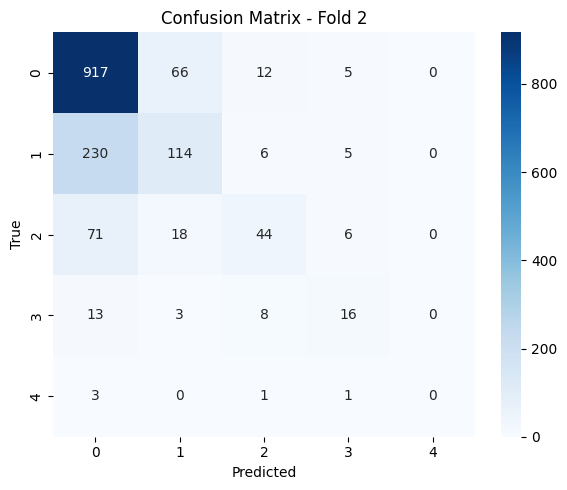

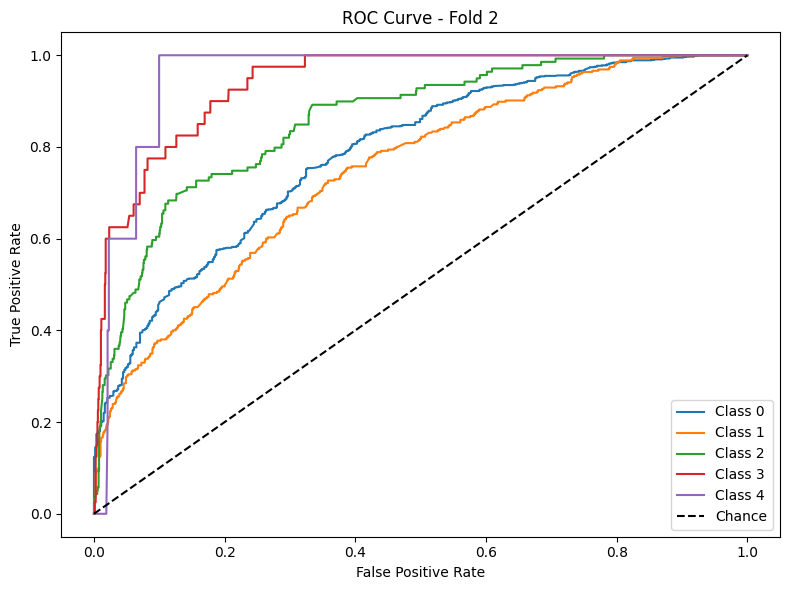

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 6s - 31ms/step - accuracy: 0.6025 - loss: 1.1924 - val_accuracy: 0.6654 - val_loss: 0.9417
Epoch 2/30
193/193 - 1s - 5ms/step - accuracy: 0.6713 - loss: 0.8833 - val_accuracy: 0.6758 - val_loss: 0.8559
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6711 - loss: 0.8229 - val_accuracy: 0.6810 - val_loss: 0.8219
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6852 - loss: 0.7874 - val_accuracy: 0.6803 - val_loss: 0.8091
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6856 - loss: 0.7656 - val_accuracy: 0.6777 - val_loss: 0.7930
Epoch 6/30
193/193 - 1s - 5ms/step - accuracy: 0.6908 - loss: 0.7570 - val_accuracy: 0.6823 - val_loss: 0.7807
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6909 - loss: 0.7500 - val_accuracy: 0.6810 - val_loss: 0.7759
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6978 - loss: 0.7434 - val_accuracy: 0.6849 - val_loss: 0.7705
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6995 - loss: 0.7297 - val_accuracy: 0.6927 - val_loss: 0.7592
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


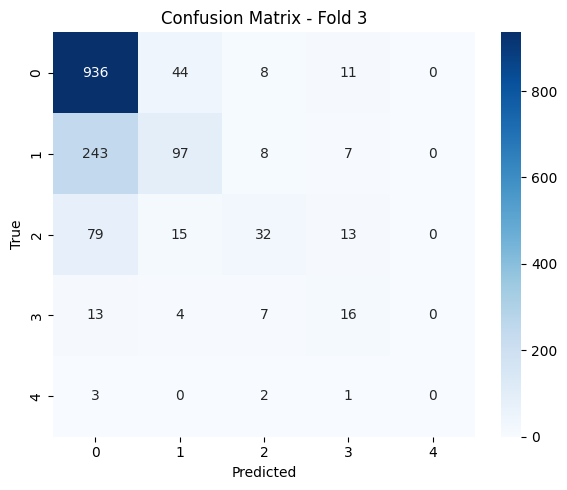

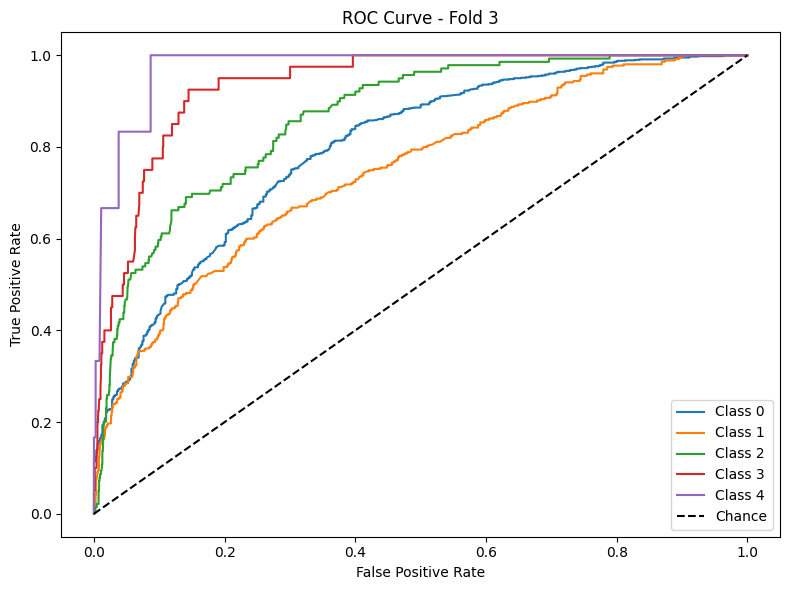

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 21ms/step - accuracy: 0.6042 - loss: 1.1848 - val_accuracy: 0.6684 - val_loss: 0.9516
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6665 - loss: 0.8919 - val_accuracy: 0.6704 - val_loss: 0.8438
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6767 - loss: 0.8195 - val_accuracy: 0.6769 - val_loss: 0.8102
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6780 - loss: 0.7895 - val_accuracy: 0.6860 - val_loss: 0.7896
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6868 - loss: 0.7773 - val_accuracy: 0.6886 - val_loss: 0.7789
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6946 - loss: 0.7576 - val_accuracy: 0.6918 - val_loss: 0.7758
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6978 - loss: 0.7473 - val_accuracy: 0.6951 - val_loss: 0.7652
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6942 - loss: 0.7406 - val_accuracy: 0.6951 - val_loss: 0.7551
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6994 - loss: 0.7285 - val_accuracy: 0.6964 - val_loss: 0.7529
Epoch 10/30

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


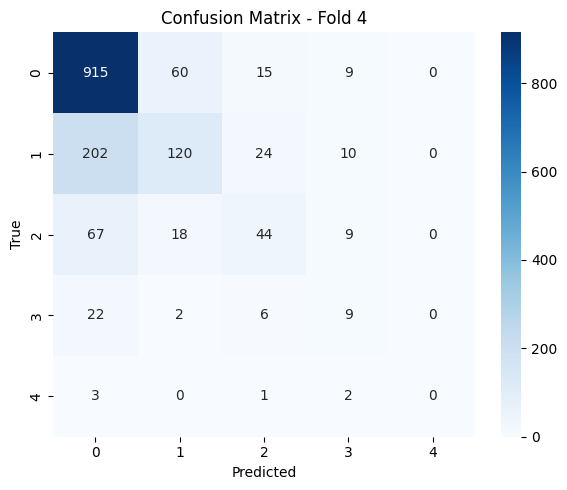

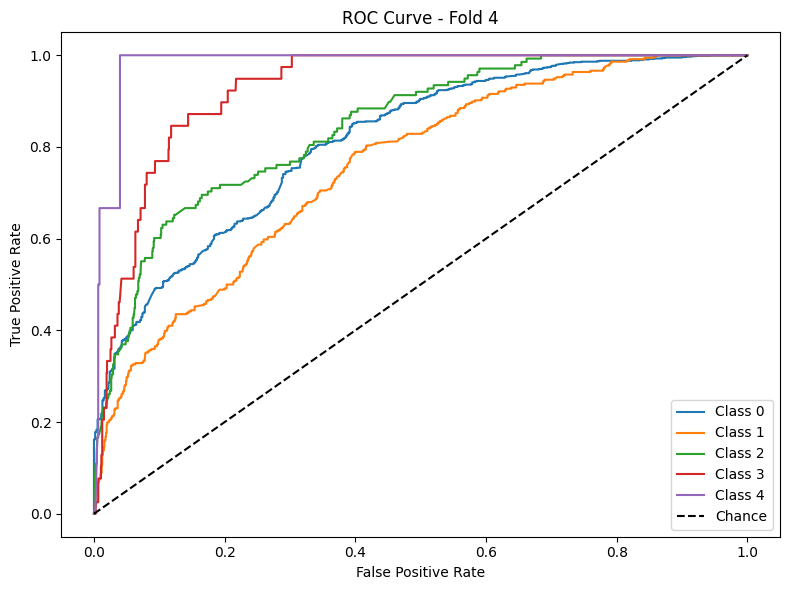

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 - 4s - 22ms/step - accuracy: 0.5920 - loss: 1.1568 - val_accuracy: 0.6678 - val_loss: 0.9281
Epoch 2/30
193/193 - 1s - 4ms/step - accuracy: 0.6690 - loss: 0.8878 - val_accuracy: 0.6795 - val_loss: 0.8258
Epoch 3/30
193/193 - 1s - 4ms/step - accuracy: 0.6781 - loss: 0.8282 - val_accuracy: 0.6860 - val_loss: 0.7981
Epoch 4/30
193/193 - 1s - 4ms/step - accuracy: 0.6799 - loss: 0.7981 - val_accuracy: 0.6860 - val_loss: 0.7769
Epoch 5/30
193/193 - 1s - 4ms/step - accuracy: 0.6872 - loss: 0.7746 - val_accuracy: 0.6743 - val_loss: 0.7676
Epoch 6/30
193/193 - 1s - 4ms/step - accuracy: 0.6918 - loss: 0.7613 - val_accuracy: 0.6912 - val_loss: 0.7548
Epoch 7/30
193/193 - 1s - 4ms/step - accuracy: 0.6954 - loss: 0.7471 - val_accuracy: 0.6886 - val_loss: 0.7561
Epoch 8/30
193/193 - 1s - 4ms/step - accuracy: 0.6924 - loss: 0.7425 - val_accuracy: 0.6944 - val_loss: 0.7531
Epoch 9/30
193/193 - 1s - 4ms/step - accuracy: 0.6950 - loss: 0.7370 - val_accuracy: 0.6912 - val_loss: 0.7414
Epoch 10/30

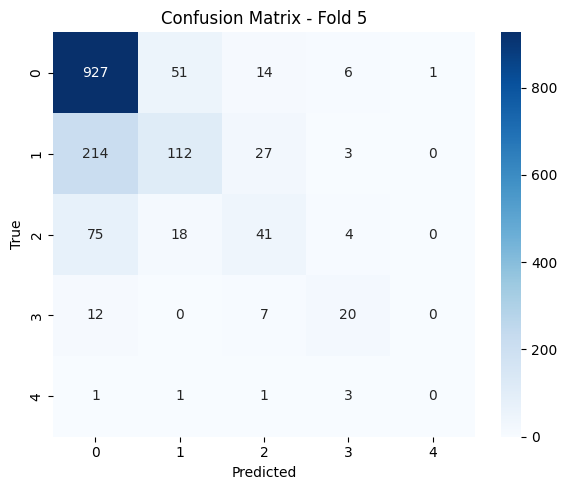

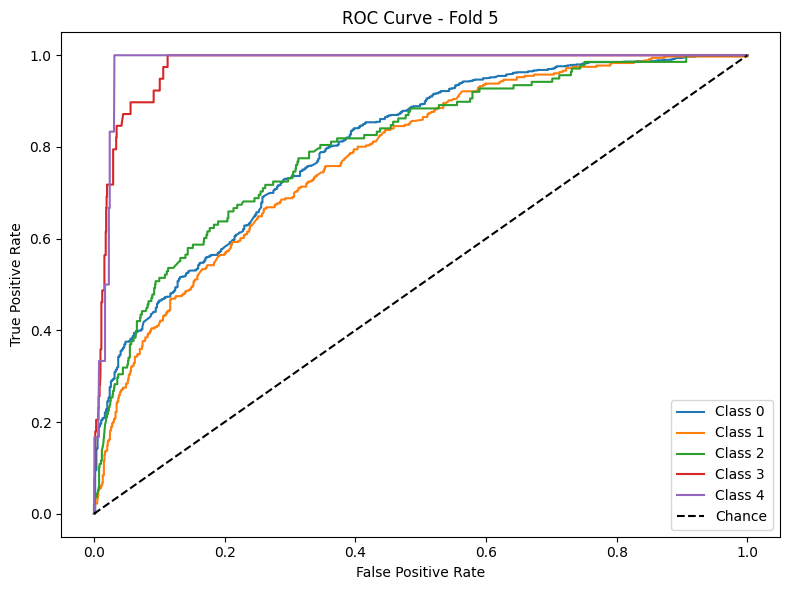


Average Accuracy: 0.7069
Average F1 Macro: 0.3925
Average AUC: 0.8595


In [12]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # Lưu model keras với .h5
    model.save(f"best_model_{temp}_phase{i}.h5")

    # Lưu scaler sklearn bình thường
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


## Predict on Test Data

In [13]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
from tensorflow.keras.models import load_model

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = load_model(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded'].values  # dạng mảng numpy
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # reshape cho LSTM input: (samples, timesteps=1, features)
    X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

    # Predict probabilities & labels
    y_pred_prob = model.predict(X_test_lstm)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Get unique classes from y_test (hoặc xác định từ dữ liệu train)
    classes = np.unique(np.concatenate((y_test, y_pred)))

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       568
           1       0.31      0.24      0.27        63
           2       0.35      0.16      0.22        43
           3       0.25      0.07      0.11        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.36      0.29      0.30       698
weighted avg       0.77      0.82      0.79       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


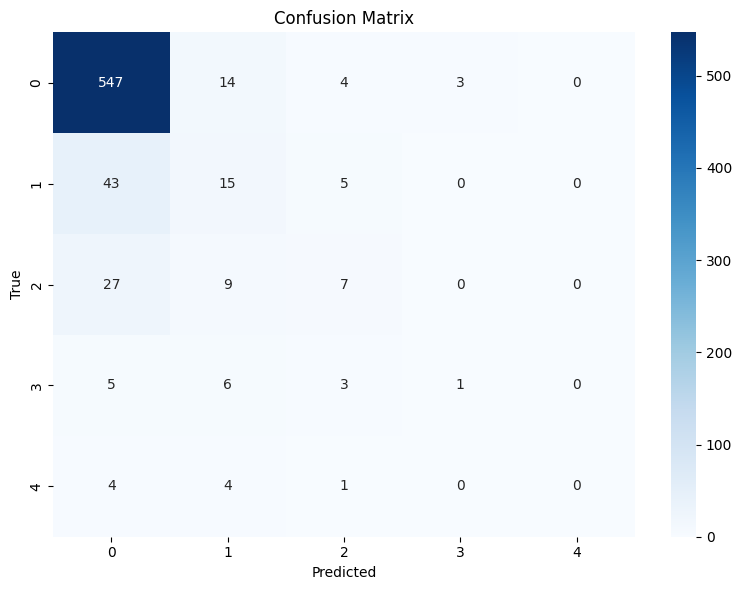


Test AUC (macro-average, OVR): 0.7169


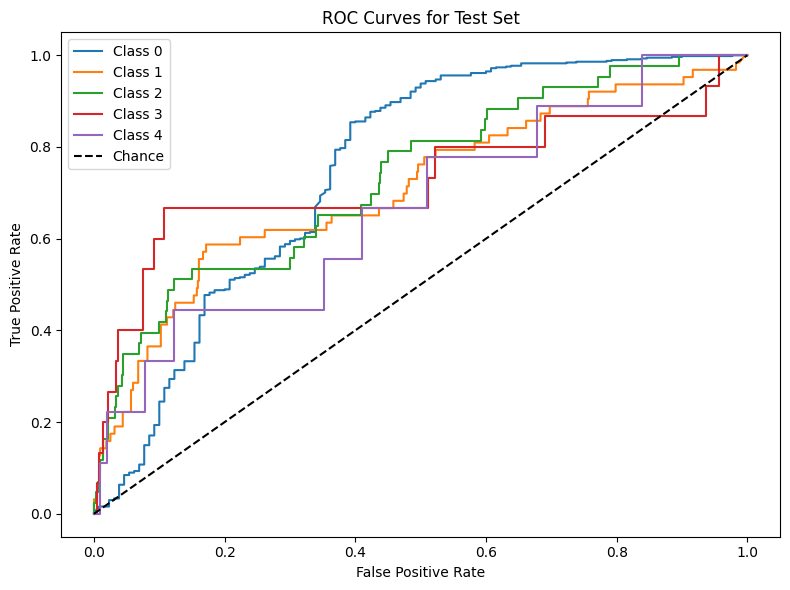

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       544
           1       0.29      0.17      0.22        59
           2       0.30      0.14      0.19        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.29      0.26      0.26       668
weighted avg       0.75      0.82      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


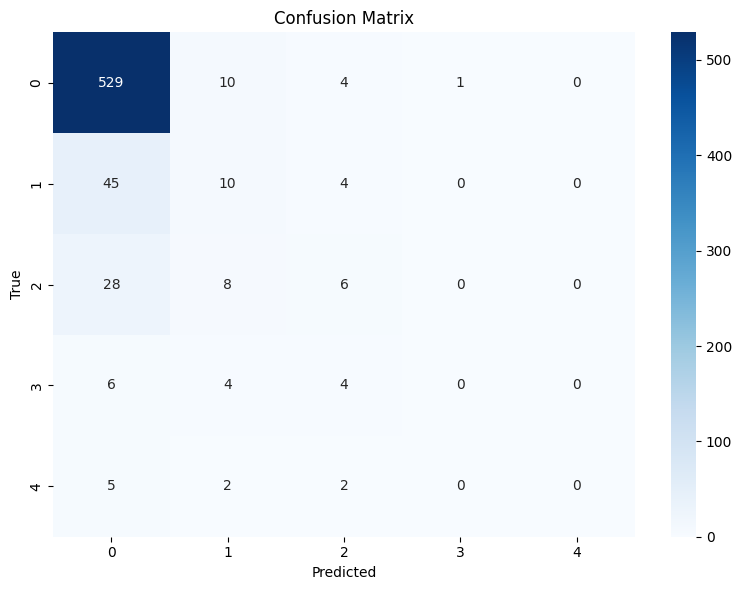


Test AUC (macro-average, OVR): 0.7833


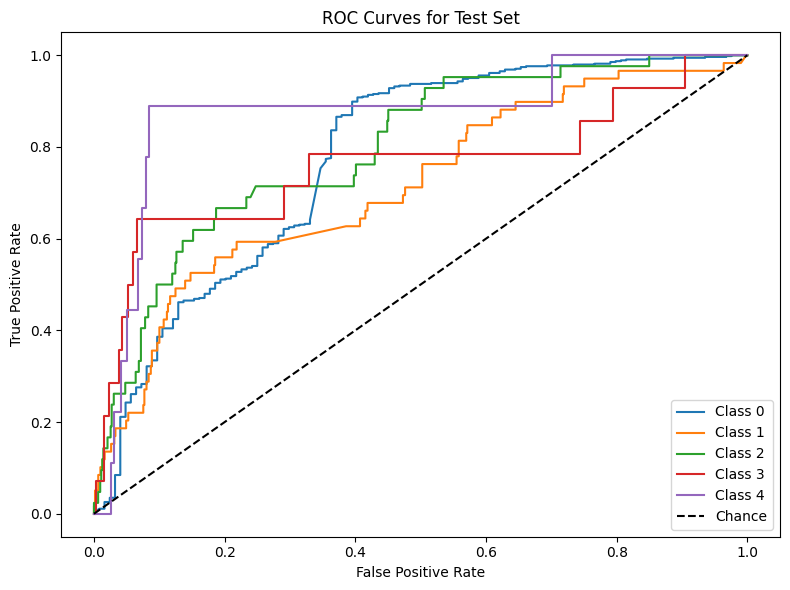

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       455
           1       0.28      0.13      0.18        52
           2       0.30      0.28      0.29        29
           3       1.00      0.10      0.18        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       554
   macro avg       0.49      0.30      0.32       554
weighted avg       0.79      0.83      0.80       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


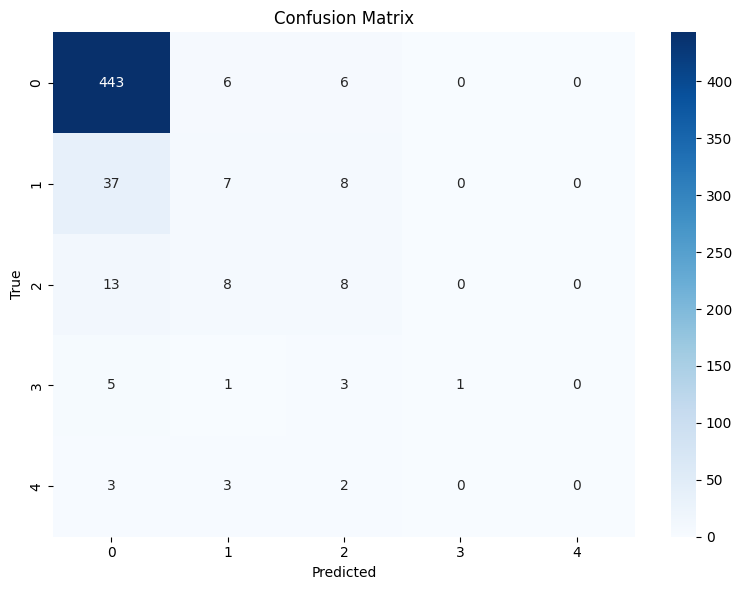


Test AUC (macro-average, OVR): 0.7323


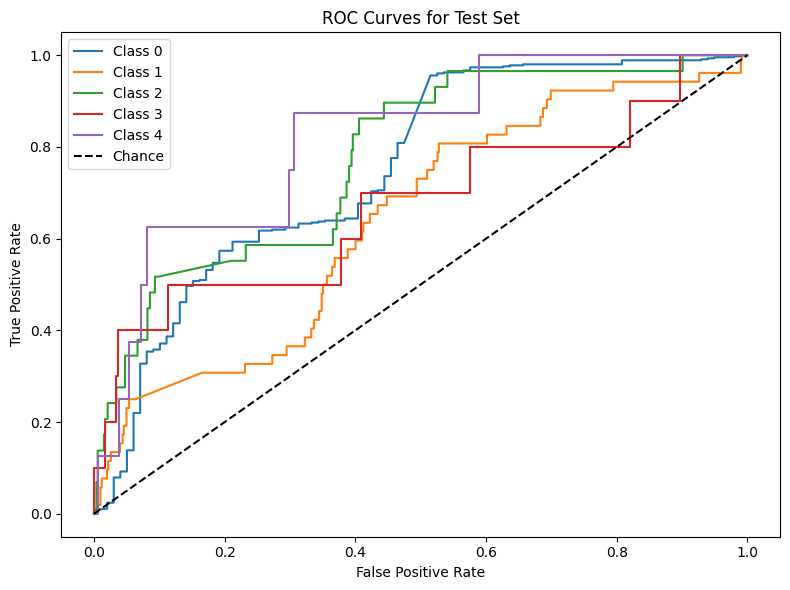

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       395
           1       0.32      0.17      0.23        40
           2       0.22      0.29      0.25        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       477
   macro avg       0.28      0.28      0.28       477
weighted avg       0.77      0.82      0.79       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


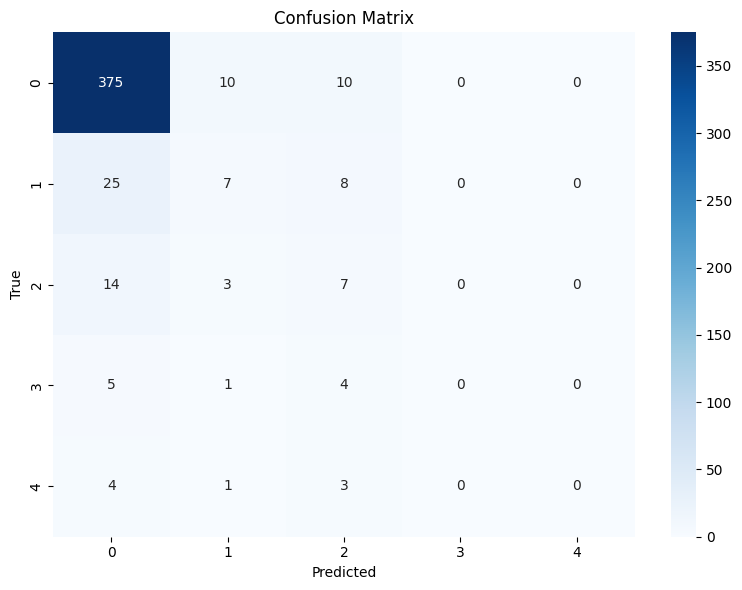


Test AUC (macro-average, OVR): 0.7587


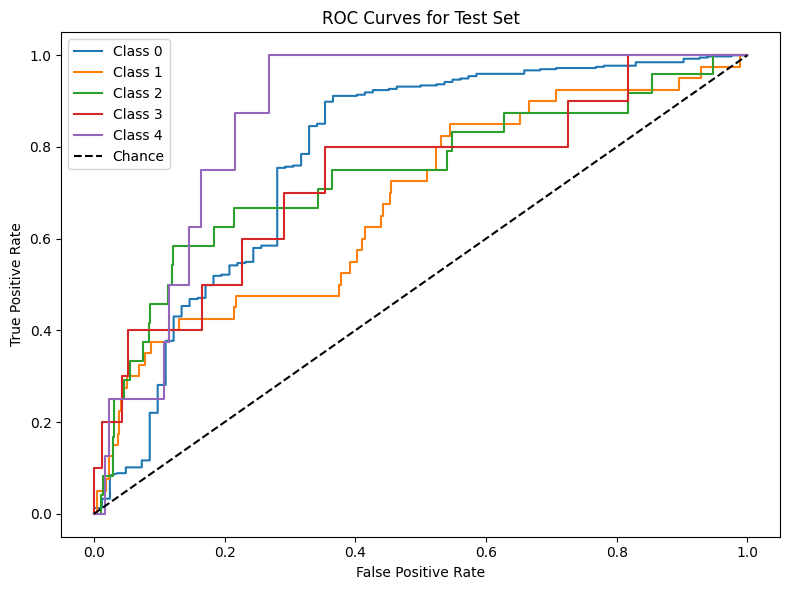

In [14]:
import glob

# temp = "sample"  # hoặc "no_sample" tùy cách lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.5823 - loss: 1.0428 - val_accuracy: 0.5215 - val_loss: 1.0591
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6461 - loss: 0.8648 - val_accuracy: 0.5794 - val_loss: 0.9685
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6604 - loss: 0.8219 - val_accuracy: 0.5687 - val_loss: 0.9794
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6701 - loss: 0.7952 - val_accuracy: 0.5923 - val_loss: 0.9394
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6801 - loss: 0.7824 - val_accuracy: 0.5282 - val_loss: 0.9842
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6869 - loss: 0.7661 - val_accuracy: 0.5576 - val_loss: 0.9625
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6902 - loss: 0.7574 - val_accuracy: 0.5816 - val_loss: 0.9448
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.6973 - loss: 0.7488 - val_accuracy: 0.5691 - val_loss: 0.9412
Epoch 9/30
987/987 - 4s - 4ms/step - accuracy: 0.6986 - loss: 0.7408 - val_accuracy: 0.6147 - val_loss: 0.9218
Epoch 10/30


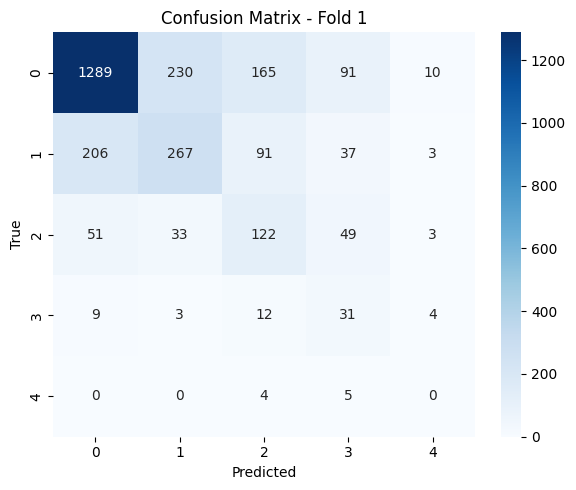

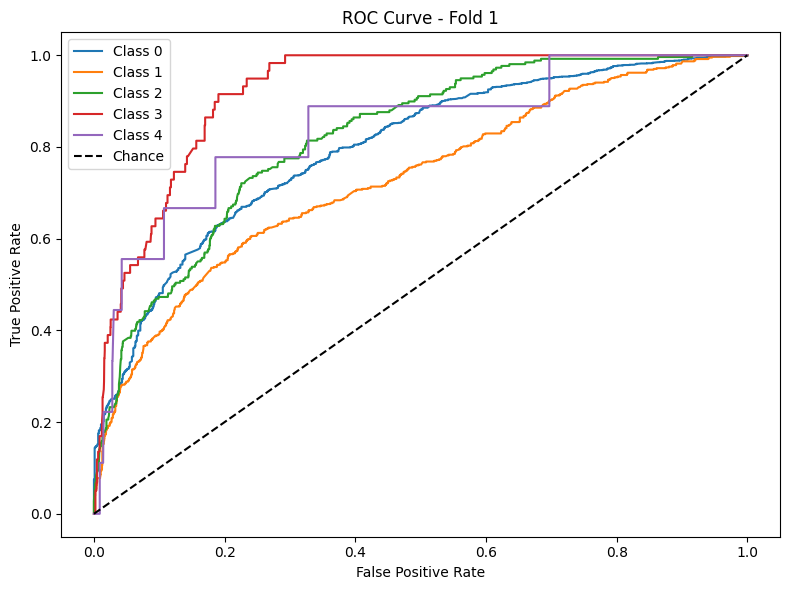

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
987/987 - 7s - 7ms/step - accuracy: 0.5959 - loss: 1.0171 - val_accuracy: 0.5217 - val_loss: 1.0712
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6624 - loss: 0.8429 - val_accuracy: 0.5184 - val_loss: 1.0144
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6751 - loss: 0.8069 - val_accuracy: 0.5682 - val_loss: 0.9735
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6817 - loss: 0.7845 - val_accuracy: 0.5689 - val_loss: 0.9686
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6893 - loss: 0.7695 - val_accuracy: 0.5578 - val_loss: 0.9456
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6953 - loss: 0.7542 - val_accuracy: 0.5527 - val_loss: 0.9549
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6955 - loss: 0.7510 - val_accuracy: 0.5453 - val_loss: 0.9465
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7055 - loss: 0.7352 - val_accuracy: 0.5615 - val_loss: 0.9635
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.7071 - loss: 0.7326 - val_accuracy: 0.5711 - val_loss: 0.9442
E

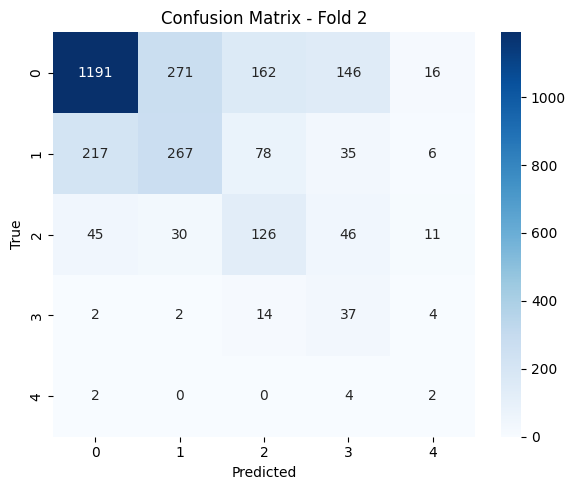

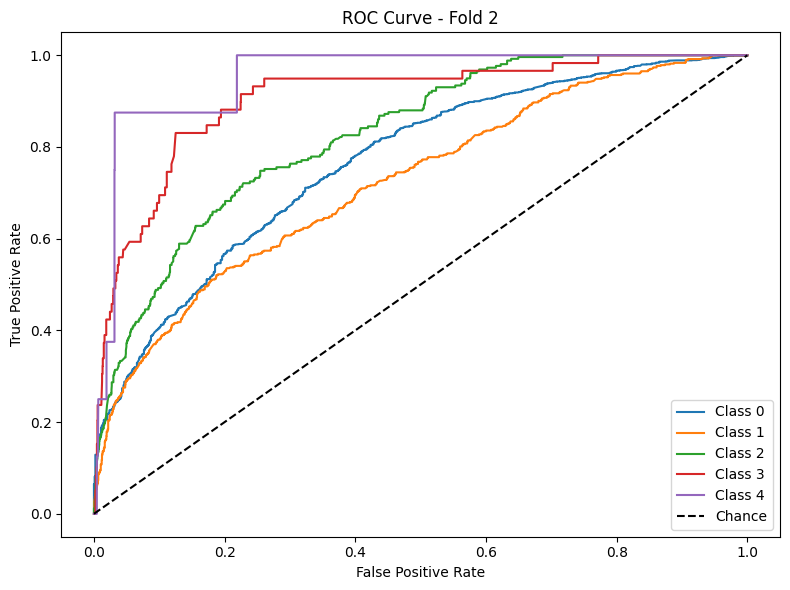

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 7ms/step - accuracy: 0.5823 - loss: 1.0175 - val_accuracy: 0.5435 - val_loss: 1.0228
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6546 - loss: 0.8355 - val_accuracy: 0.5520 - val_loss: 0.9721
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6734 - loss: 0.7948 - val_accuracy: 0.5634 - val_loss: 0.9517
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6839 - loss: 0.7733 - val_accuracy: 0.5763 - val_loss: 0.9417
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6902 - loss: 0.7540 - val_accuracy: 0.5903 - val_loss: 0.9262
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6988 - loss: 0.7406 - val_accuracy: 0.5601 - val_loss: 0.9322
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.7052 - loss: 0.7317 - val_accuracy: 0.5892 - val_loss: 0.9127
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7096 - loss: 0.7204 - val_accuracy: 0.5836 - val_loss: 0.9190
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.7124 - loss: 0.7145 - val_accuracy: 0.5707 - val_loss: 0.9229
Epoch 10/30


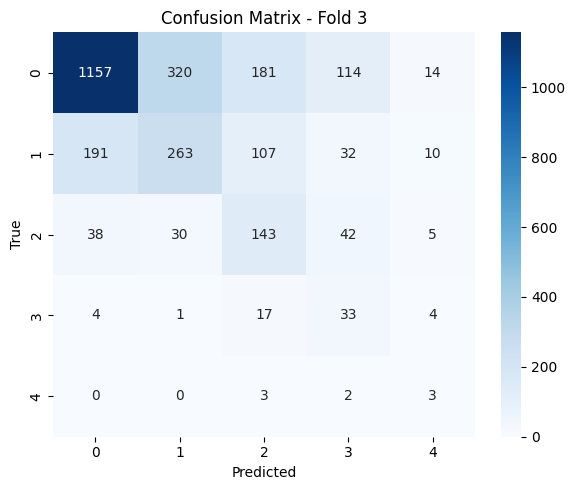

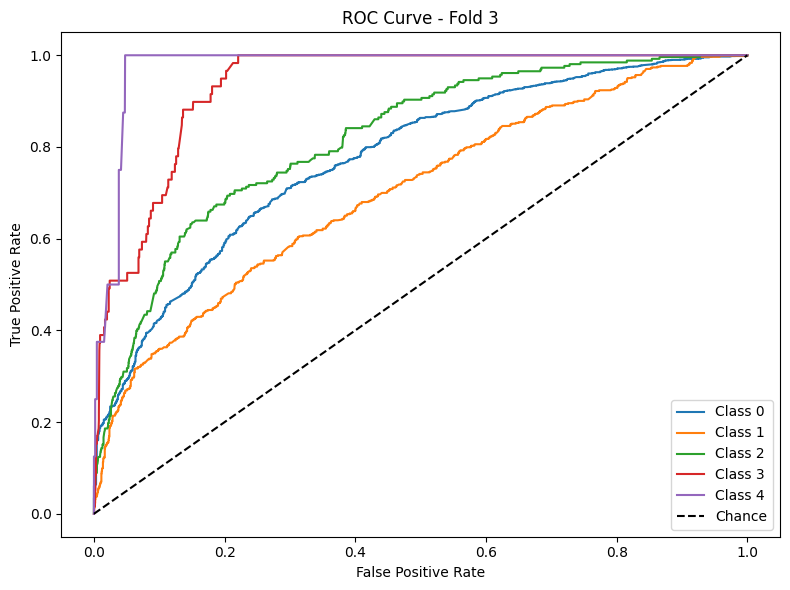

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.5847 - loss: 1.0386 - val_accuracy: 0.5236 - val_loss: 1.0375
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6573 - loss: 0.8496 - val_accuracy: 0.5685 - val_loss: 0.9729
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6718 - loss: 0.8072 - val_accuracy: 0.5626 - val_loss: 0.9598
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6808 - loss: 0.7833 - val_accuracy: 0.5413 - val_loss: 0.9464
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6909 - loss: 0.7669 - val_accuracy: 0.5932 - val_loss: 0.9128
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6935 - loss: 0.7533 - val_accuracy: 0.6054 - val_loss: 0.9069
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.6967 - loss: 0.7414 - val_accuracy: 0.6146 - val_loss: 0.8910
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7021 - loss: 0.7316 - val_accuracy: 0.5921 - val_loss: 0.9172
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.7052 - loss: 0.7209 - val_accuracy: 0.5969 - val_loss: 0.9027
Epoch 10/30


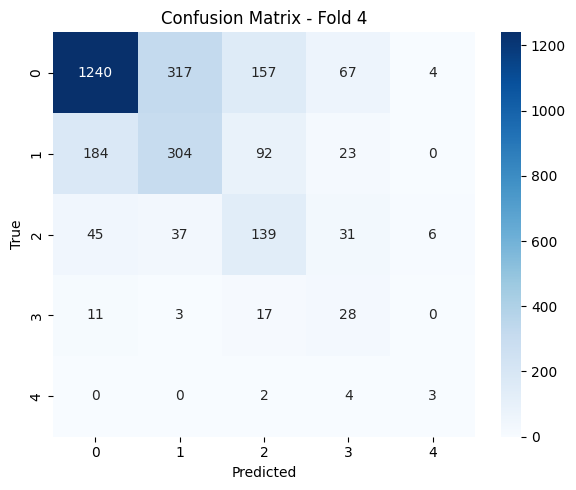

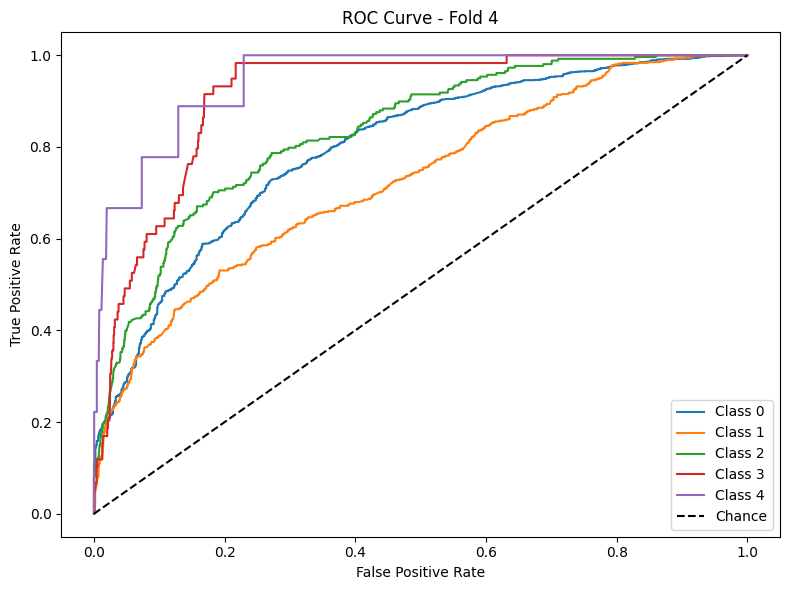

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


987/987 - 6s - 6ms/step - accuracy: 0.5912 - loss: 1.0204 - val_accuracy: 0.5442 - val_loss: 1.0248
Epoch 2/30
987/987 - 3s - 3ms/step - accuracy: 0.6600 - loss: 0.8440 - val_accuracy: 0.5700 - val_loss: 0.9849
Epoch 3/30
987/987 - 3s - 3ms/step - accuracy: 0.6760 - loss: 0.8046 - val_accuracy: 0.5884 - val_loss: 0.9492
Epoch 4/30
987/987 - 3s - 3ms/step - accuracy: 0.6898 - loss: 0.7820 - val_accuracy: 0.6032 - val_loss: 0.9207
Epoch 5/30
987/987 - 3s - 3ms/step - accuracy: 0.6933 - loss: 0.7654 - val_accuracy: 0.5976 - val_loss: 0.9210
Epoch 6/30
987/987 - 3s - 3ms/step - accuracy: 0.6990 - loss: 0.7522 - val_accuracy: 0.5995 - val_loss: 0.9328
Epoch 7/30
987/987 - 3s - 3ms/step - accuracy: 0.7048 - loss: 0.7378 - val_accuracy: 0.6032 - val_loss: 0.9295
Epoch 8/30
987/987 - 3s - 3ms/step - accuracy: 0.7108 - loss: 0.7313 - val_accuracy: 0.6139 - val_loss: 0.8920
Epoch 9/30
987/987 - 3s - 3ms/step - accuracy: 0.7114 - loss: 0.7255 - val_accuracy: 0.5763 - val_loss: 0.9149
Epoch 10/30


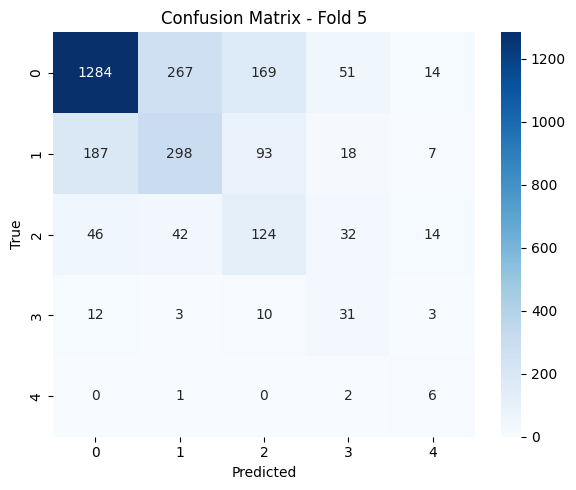

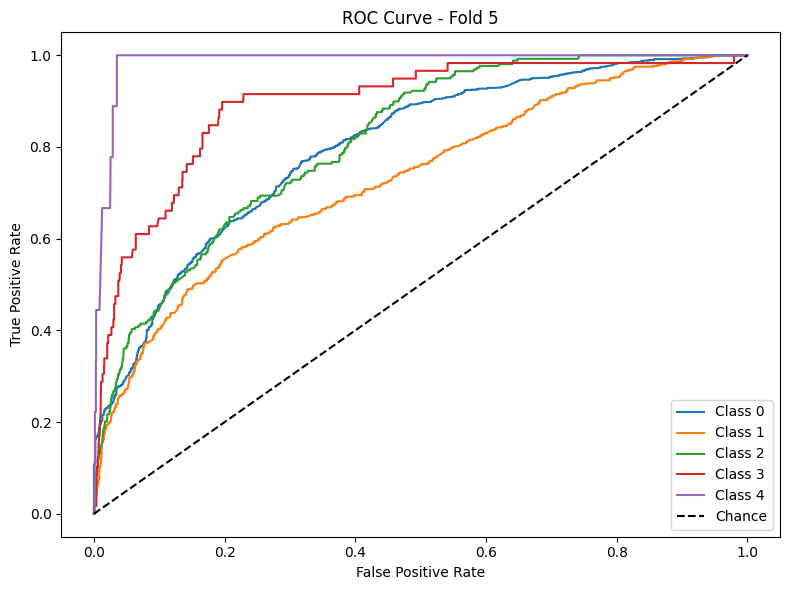


Average Accuracy: 0.6181
Average F1 Macro: 0.4025
Average AUC: 0.8369

=== Training Phase 2 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 8s - 9ms/step - accuracy: 0.5977 - loss: 1.0337 - val_accuracy: 0.4712 - val_loss: 1.1316
Epoch 2/30
824/824 - 3s - 3ms/step - accuracy: 0.6610 - loss: 0.8341 - val_accuracy: 0.5611 - val_loss: 1.0096
Epoch 3/30
824/824 - 3s - 3ms/step - accuracy: 0.6771 - loss: 0.7912 - val_accuracy: 0.5624 - val_loss: 1.0096
Epoch 4/30
824/824 - 3s - 3ms/step - accuracy: 0.6869 - loss: 0.7706 - val_accuracy: 0.5496 - val_loss: 1.0175
Epoch 5/30
824/824 - 3s - 3ms/step - accuracy: 0.6952 - loss: 0.7529 - val_accuracy: 0.5686 - val_loss: 0.9792
Epoch 6/30
824/824 - 3s - 3ms/step - accuracy: 0.6989 - loss: 0.7416 - val_accuracy: 0.5664 - val_loss: 0.9786
Epoch 7/30
824/824 - 3s - 3ms/step - accuracy: 0.7010 - loss: 0.7344 - val_accuracy: 0.5624 - val_loss: 0.9577
Epoch 8/30
824/824 - 3s - 3ms/step - accuracy: 0.7064 - loss: 0.7233 - val_accuracy: 0.5872 - val_loss: 0.9430
Epoch 9/30
824/824 - 3s - 3ms/step - accuracy: 0.7107 - loss: 0.7153 - val_accuracy: 0.5770 - val_loss: 0.9564
Epoch 10/30


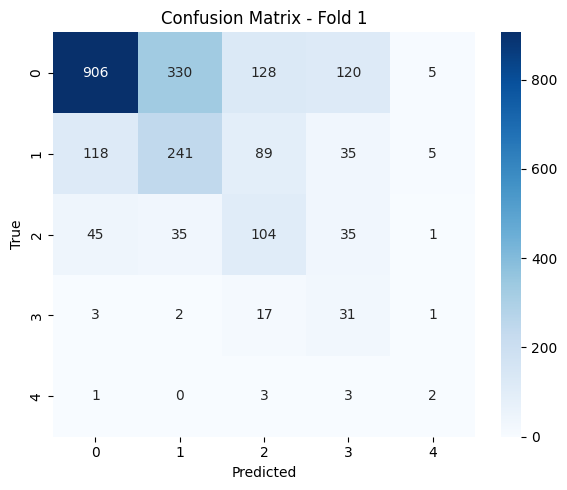

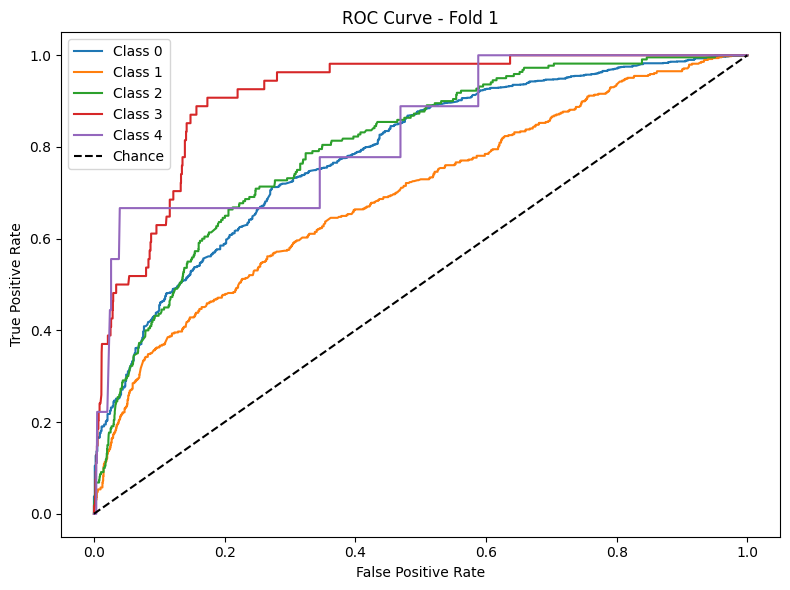

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 7s - 8ms/step - accuracy: 0.5917 - loss: 1.0263 - val_accuracy: 0.5810 - val_loss: 1.0321
Epoch 2/30
824/824 - 3s - 4ms/step - accuracy: 0.6621 - loss: 0.8204 - val_accuracy: 0.5527 - val_loss: 1.0061
Epoch 3/30
824/824 - 3s - 4ms/step - accuracy: 0.6770 - loss: 0.7834 - val_accuracy: 0.5867 - val_loss: 0.9753
Epoch 4/30
824/824 - 3s - 4ms/step - accuracy: 0.6878 - loss: 0.7585 - val_accuracy: 0.5619 - val_loss: 0.9767
Epoch 5/30
824/824 - 3s - 3ms/step - accuracy: 0.6972 - loss: 0.7380 - val_accuracy: 0.5850 - val_loss: 0.9509
Epoch 6/30
824/824 - 3s - 3ms/step - accuracy: 0.7017 - loss: 0.7260 - val_accuracy: 0.5721 - val_loss: 0.9475
Epoch 7/30
824/824 - 3s - 3ms/step - accuracy: 0.7079 - loss: 0.7162 - val_accuracy: 0.5726 - val_loss: 0.9532
Epoch 8/30
824/824 - 3s - 3ms/step - accuracy: 0.7130 - loss: 0.7097 - val_accuracy: 0.5673 - val_loss: 0.9542
Epoch 9/30
824/824 - 3s - 4ms/step - accuracy: 0.7134 - loss: 0.7019 - val_accuracy: 0.5664 - val_loss: 0.9572
Epoch 10/30


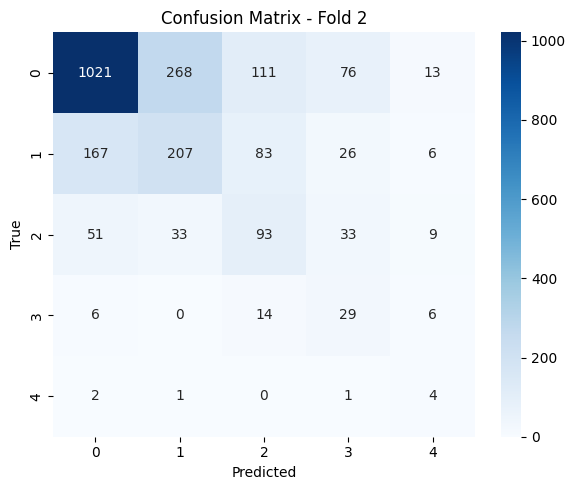

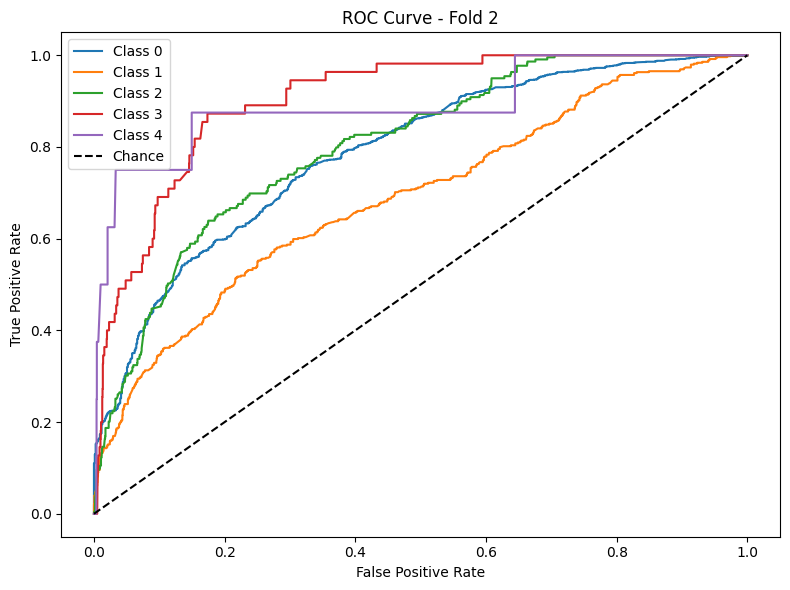

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 6s - 7ms/step - accuracy: 0.5965 - loss: 1.0165 - val_accuracy: 0.5188 - val_loss: 1.0810
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6685 - loss: 0.8237 - val_accuracy: 0.5325 - val_loss: 1.0545
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.6837 - loss: 0.7833 - val_accuracy: 0.5649 - val_loss: 1.0004
Epoch 4/30
824/824 - 3s - 3ms/step - accuracy: 0.6945 - loss: 0.7618 - val_accuracy: 0.5675 - val_loss: 0.9892
Epoch 5/30
824/824 - 3s - 3ms/step - accuracy: 0.7029 - loss: 0.7424 - val_accuracy: 0.5640 - val_loss: 1.0176
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7040 - loss: 0.7323 - val_accuracy: 0.5609 - val_loss: 1.0002
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7123 - loss: 0.7172 - val_accuracy: 0.5830 - val_loss: 0.9809
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7145 - loss: 0.7115 - val_accuracy: 0.5511 - val_loss: 1.0067
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7159 - loss: 0.7067 - val_accuracy: 0.5839 - val_loss: 0.9691
Epoch 10/30


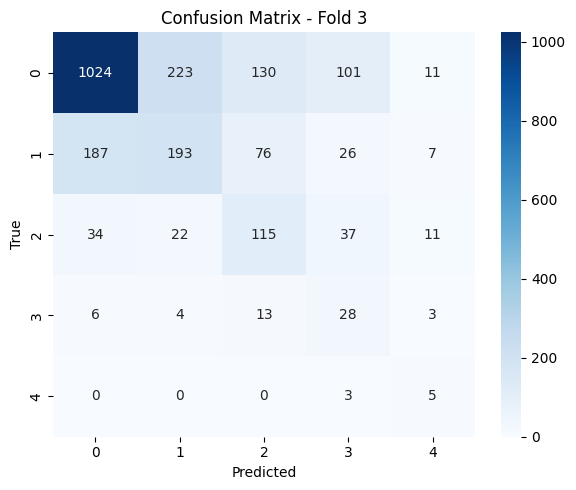

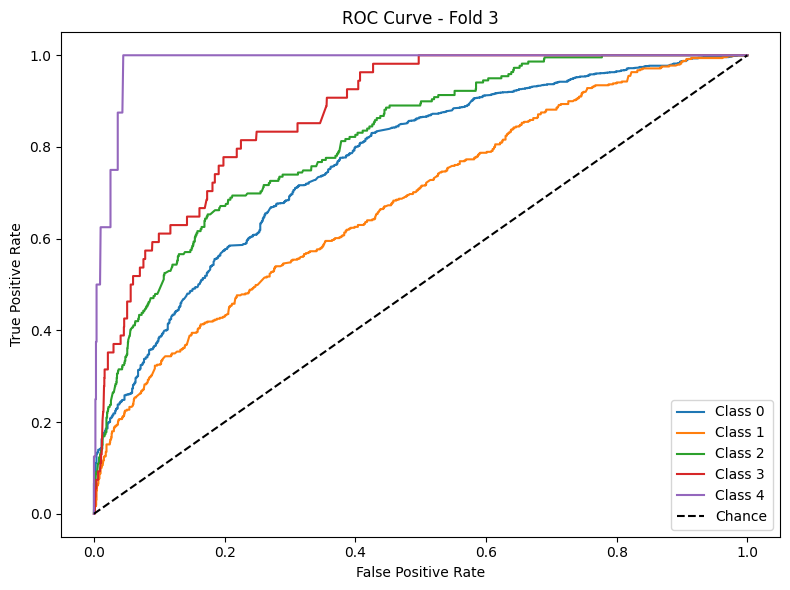

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 5s - 6ms/step - accuracy: 0.5910 - loss: 1.0336 - val_accuracy: 0.5347 - val_loss: 1.0306
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6605 - loss: 0.8430 - val_accuracy: 0.5781 - val_loss: 0.9674
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.6770 - loss: 0.8026 - val_accuracy: 0.5520 - val_loss: 0.9853
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.6842 - loss: 0.7837 - val_accuracy: 0.5657 - val_loss: 0.9473
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.6937 - loss: 0.7678 - val_accuracy: 0.5635 - val_loss: 0.9504
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.6978 - loss: 0.7488 - val_accuracy: 0.5635 - val_loss: 0.9592
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7006 - loss: 0.7441 - val_accuracy: 0.6038 - val_loss: 0.9191
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7080 - loss: 0.7334 - val_accuracy: 0.5741 - val_loss: 0.9401
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7082 - loss: 0.7284 - val_accuracy: 0.5919 - val_loss: 0.9096
Epoch 10/30


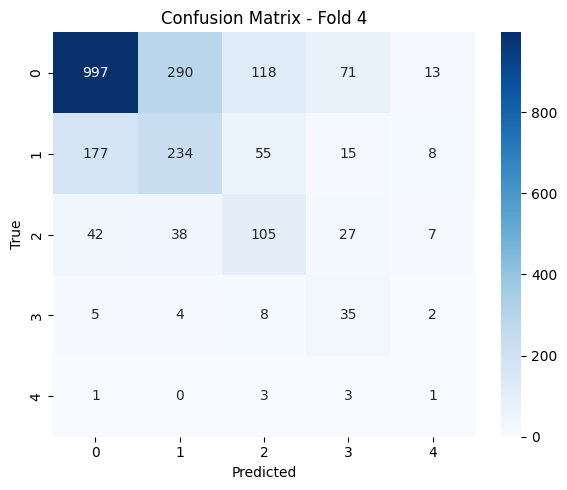

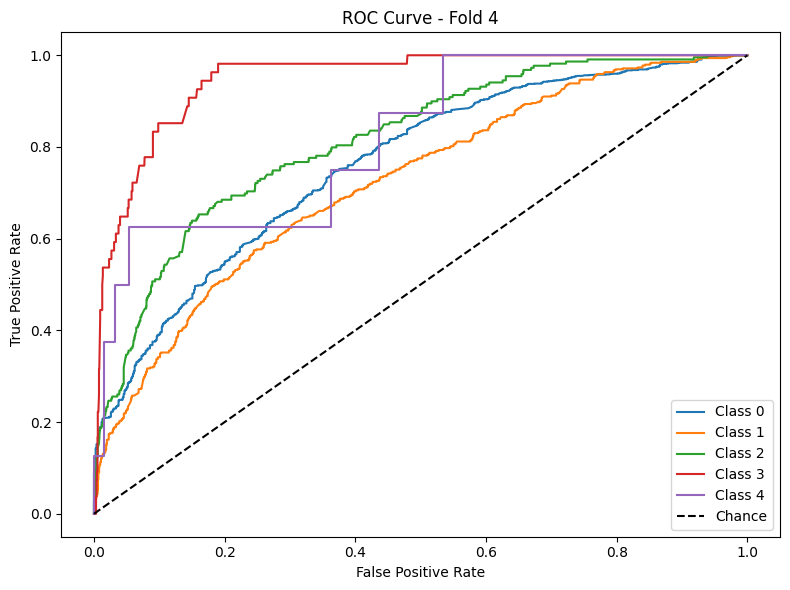

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


824/824 - 5s - 7ms/step - accuracy: 0.5848 - loss: 1.0421 - val_accuracy: 0.5582 - val_loss: 1.0335
Epoch 2/30
824/824 - 2s - 3ms/step - accuracy: 0.6552 - loss: 0.8418 - val_accuracy: 0.5502 - val_loss: 1.0063
Epoch 3/30
824/824 - 2s - 3ms/step - accuracy: 0.6723 - loss: 0.7984 - val_accuracy: 0.5511 - val_loss: 0.9800
Epoch 4/30
824/824 - 2s - 3ms/step - accuracy: 0.6841 - loss: 0.7733 - val_accuracy: 0.5684 - val_loss: 0.9694
Epoch 5/30
824/824 - 2s - 3ms/step - accuracy: 0.6949 - loss: 0.7559 - val_accuracy: 0.5817 - val_loss: 0.9499
Epoch 6/30
824/824 - 2s - 3ms/step - accuracy: 0.7017 - loss: 0.7396 - val_accuracy: 0.5874 - val_loss: 0.9671
Epoch 7/30
824/824 - 2s - 3ms/step - accuracy: 0.7033 - loss: 0.7352 - val_accuracy: 0.5737 - val_loss: 0.9383
Epoch 8/30
824/824 - 2s - 3ms/step - accuracy: 0.7074 - loss: 0.7241 - val_accuracy: 0.5821 - val_loss: 0.9427
Epoch 9/30
824/824 - 2s - 3ms/step - accuracy: 0.7099 - loss: 0.7163 - val_accuracy: 0.5688 - val_loss: 0.9449
Epoch 10/30


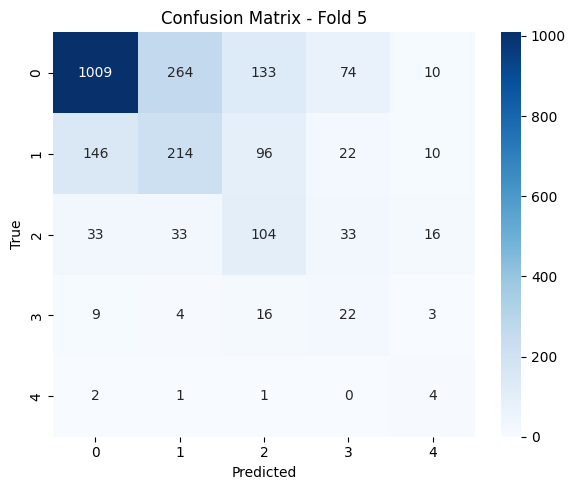

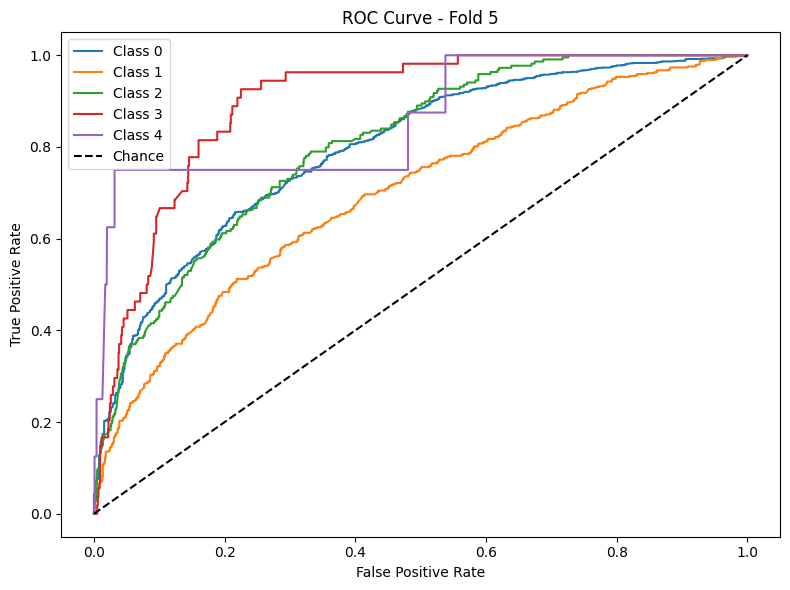


Average Accuracy: 0.5956
Average F1 Macro: 0.3918
Average AUC: 0.8139

=== Training Phase 3 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 7s - 9ms/step - accuracy: 0.5880 - loss: 1.0252 - val_accuracy: 0.5887 - val_loss: 1.0404
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6733 - loss: 0.8237 - val_accuracy: 0.5829 - val_loss: 1.0200
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6984 - loss: 0.7728 - val_accuracy: 0.5897 - val_loss: 0.9814
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7075 - loss: 0.7461 - val_accuracy: 0.6133 - val_loss: 0.9295
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7121 - loss: 0.7304 - val_accuracy: 0.5728 - val_loss: 0.9630
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7226 - loss: 0.7113 - val_accuracy: 0.5921 - val_loss: 0.9430
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7308 - loss: 0.7052 - val_accuracy: 0.6095 - val_loss: 0.9256
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7293 - loss: 0.6949 - val_accuracy: 0.6234 - val_loss: 0.9334
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7320 - loss: 0.6874 - val_accuracy: 0.6336 - val_loss: 0.9123
Epoch 10/30


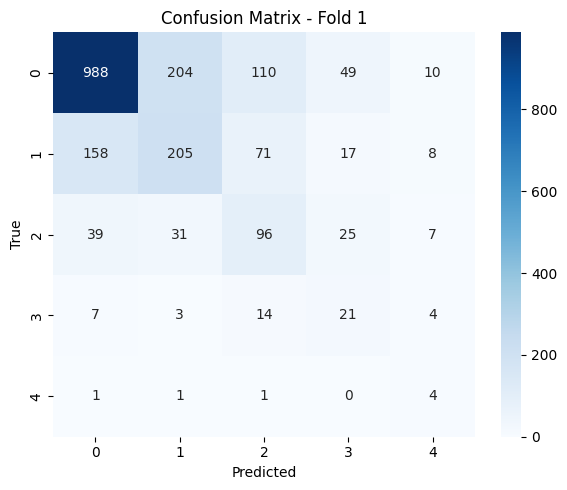

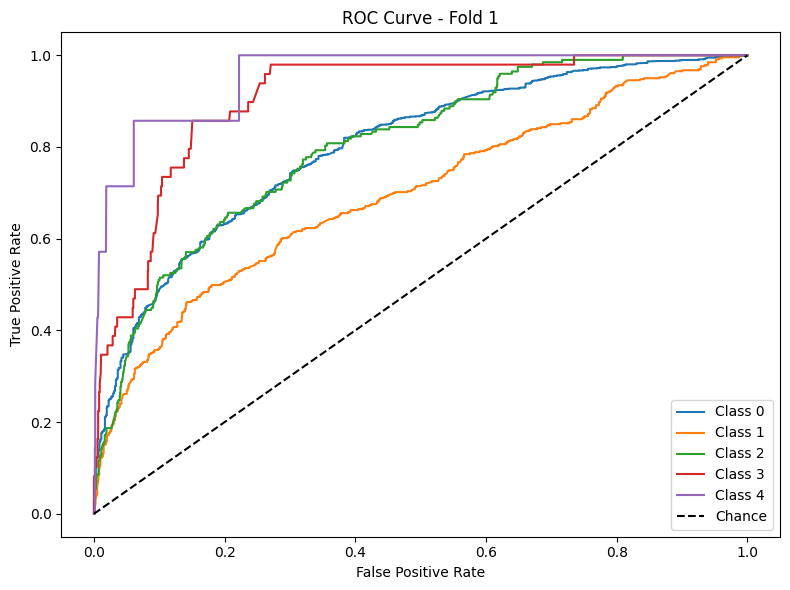

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.6042 - loss: 1.0260 - val_accuracy: 0.5887 - val_loss: 1.0220
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6714 - loss: 0.8250 - val_accuracy: 0.5791 - val_loss: 0.9990
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6934 - loss: 0.7804 - val_accuracy: 0.5506 - val_loss: 0.9642
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7014 - loss: 0.7559 - val_accuracy: 0.5916 - val_loss: 0.9310
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7076 - loss: 0.7389 - val_accuracy: 0.5974 - val_loss: 0.9498
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7191 - loss: 0.7268 - val_accuracy: 0.6123 - val_loss: 0.9240
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7250 - loss: 0.7098 - val_accuracy: 0.5781 - val_loss: 0.9392
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7238 - loss: 0.7068 - val_accuracy: 0.5945 - val_loss: 0.9298
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7241 - loss: 0.7006 - val_accuracy: 0.6104 - val_loss: 0.9066
Epoch 10/30


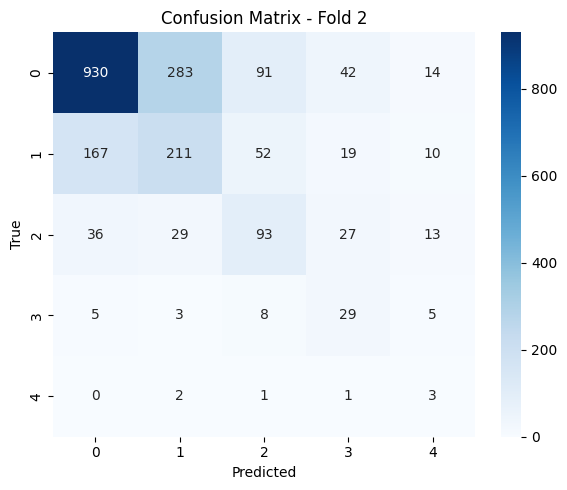

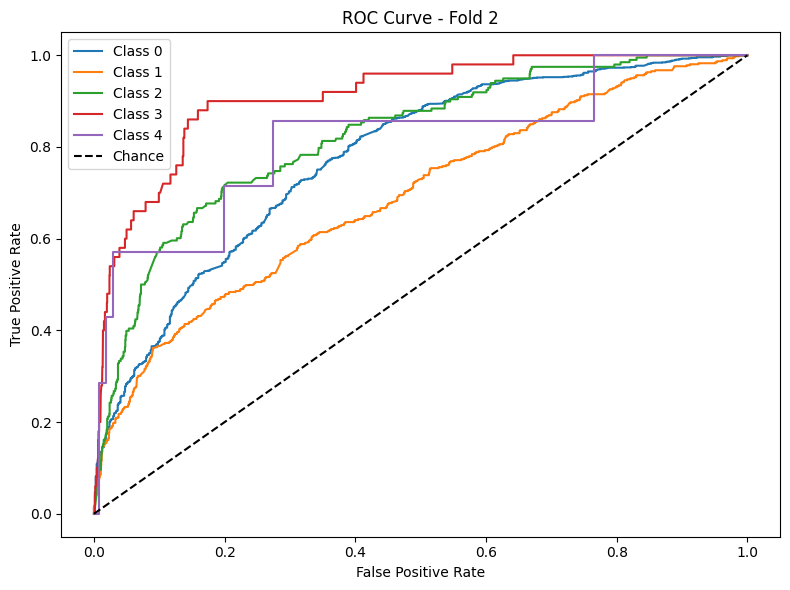

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.5831 - loss: 1.0450 - val_accuracy: 0.5304 - val_loss: 1.0449
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6645 - loss: 0.8328 - val_accuracy: 0.5352 - val_loss: 1.0371
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6871 - loss: 0.7859 - val_accuracy: 0.5347 - val_loss: 1.0018
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7006 - loss: 0.7592 - val_accuracy: 0.5516 - val_loss: 0.9949
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7104 - loss: 0.7373 - val_accuracy: 0.5535 - val_loss: 0.9921
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7157 - loss: 0.7223 - val_accuracy: 0.5511 - val_loss: 1.0099
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7162 - loss: 0.7157 - val_accuracy: 0.5646 - val_loss: 0.9780
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7210 - loss: 0.7051 - val_accuracy: 0.5550 - val_loss: 0.9749
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7231 - loss: 0.6988 - val_accuracy: 0.5598 - val_loss: 0.9579
Epoch 10/30


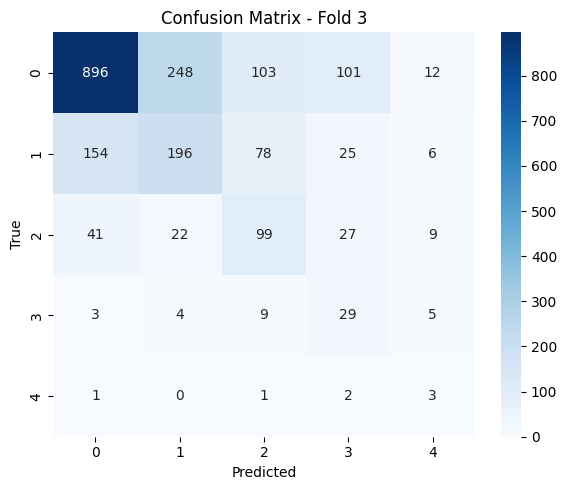

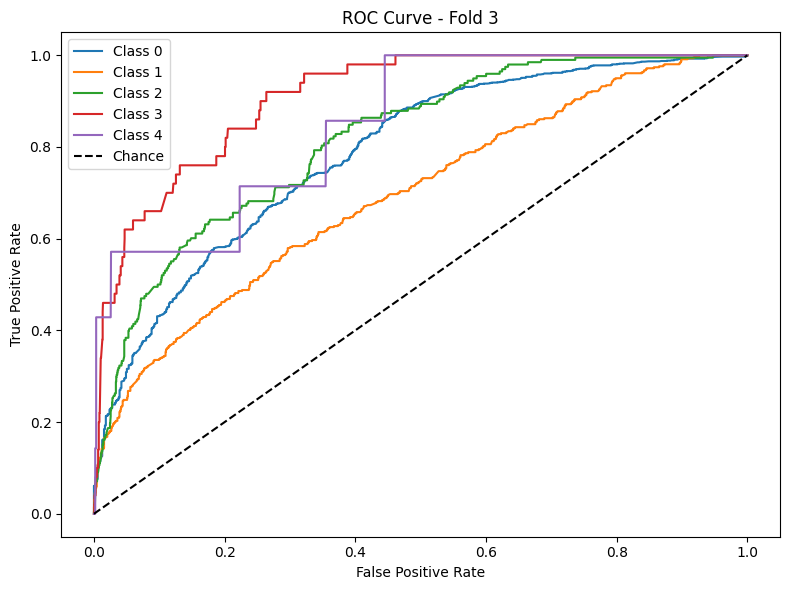

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 5s - 7ms/step - accuracy: 0.5976 - loss: 1.0221 - val_accuracy: 0.5149 - val_loss: 1.0704
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6718 - loss: 0.8297 - val_accuracy: 0.5294 - val_loss: 0.9972
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.6956 - loss: 0.7820 - val_accuracy: 0.5858 - val_loss: 0.9494
Epoch 4/30
752/752 - 2s - 3ms/step - accuracy: 0.7058 - loss: 0.7569 - val_accuracy: 0.5796 - val_loss: 0.9629
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7133 - loss: 0.7380 - val_accuracy: 0.5685 - val_loss: 0.9501
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7174 - loss: 0.7251 - val_accuracy: 0.5882 - val_loss: 0.9344
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7219 - loss: 0.7118 - val_accuracy: 0.5902 - val_loss: 0.9186
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7226 - loss: 0.7073 - val_accuracy: 0.5993 - val_loss: 0.9257
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7276 - loss: 0.6989 - val_accuracy: 0.5916 - val_loss: 0.9412
Epoch 10/30


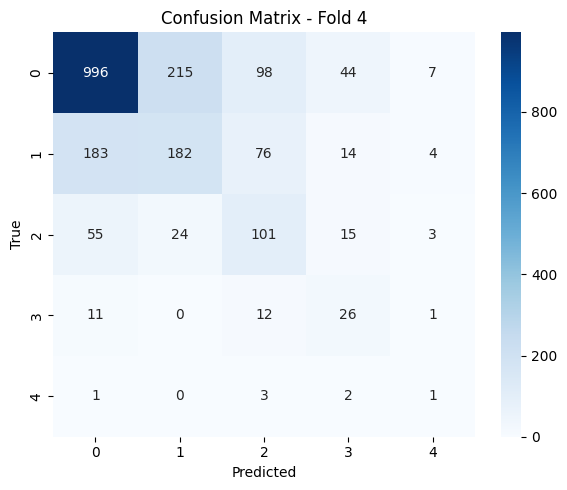

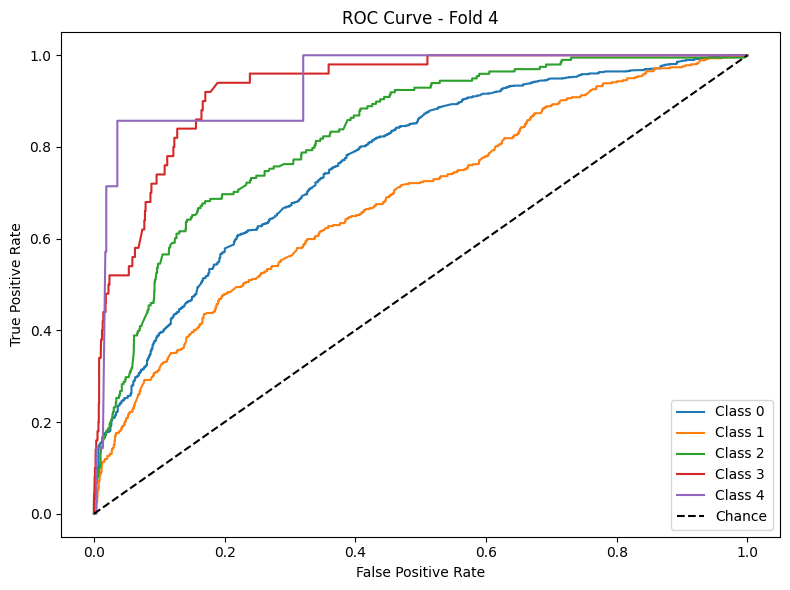

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


752/752 - 6s - 8ms/step - accuracy: 0.6090 - loss: 0.9881 - val_accuracy: 0.5731 - val_loss: 1.0388
Epoch 2/30
752/752 - 2s - 3ms/step - accuracy: 0.6858 - loss: 0.7887 - val_accuracy: 0.5601 - val_loss: 1.0060
Epoch 3/30
752/752 - 2s - 3ms/step - accuracy: 0.7039 - loss: 0.7488 - val_accuracy: 0.5808 - val_loss: 0.9961
Epoch 4/30
752/752 - 3s - 3ms/step - accuracy: 0.7119 - loss: 0.7289 - val_accuracy: 0.5909 - val_loss: 0.9762
Epoch 5/30
752/752 - 2s - 3ms/step - accuracy: 0.7211 - loss: 0.7092 - val_accuracy: 0.5895 - val_loss: 0.9917
Epoch 6/30
752/752 - 2s - 3ms/step - accuracy: 0.7281 - loss: 0.6971 - val_accuracy: 0.5813 - val_loss: 0.9938
Epoch 7/30
752/752 - 2s - 3ms/step - accuracy: 0.7302 - loss: 0.6874 - val_accuracy: 0.6064 - val_loss: 0.9705
Epoch 8/30
752/752 - 2s - 3ms/step - accuracy: 0.7345 - loss: 0.6775 - val_accuracy: 0.6015 - val_loss: 0.9769
Epoch 9/30
752/752 - 2s - 3ms/step - accuracy: 0.7342 - loss: 0.6724 - val_accuracy: 0.5909 - val_loss: 0.9587
Epoch 10/30


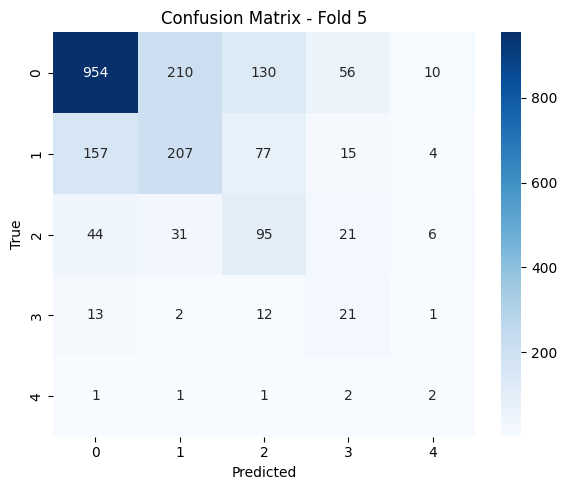

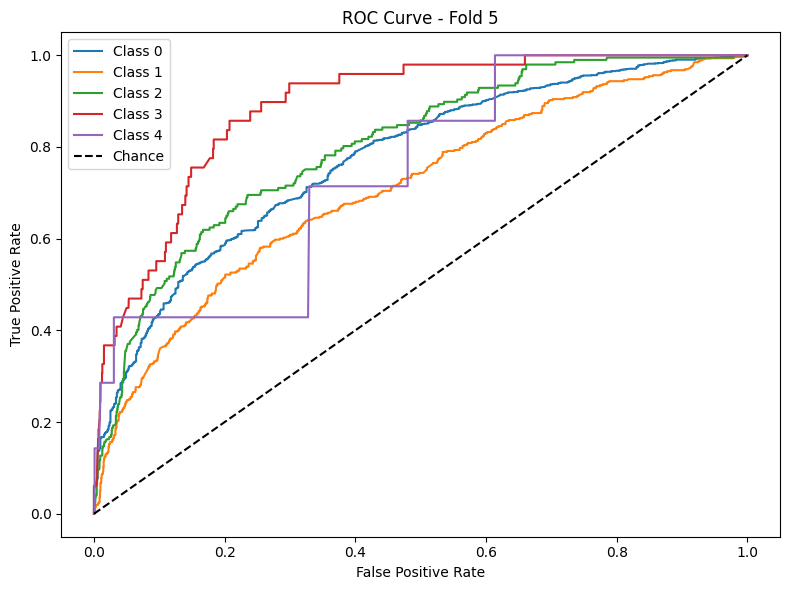


Average Accuracy: 0.6161
Average F1 Macro: 0.4030
Average AUC: 0.8116

=== Training Phase 4 ===
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 7s - 13ms/step - accuracy: 0.6177 - loss: 1.0260 - val_accuracy: 0.5387 - val_loss: 1.0788
Epoch 2/30
553/553 - 2s - 4ms/step - accuracy: 0.7015 - loss: 0.7777 - val_accuracy: 0.5705 - val_loss: 1.0155
Epoch 3/30
553/553 - 2s - 4ms/step - accuracy: 0.7203 - loss: 0.7245 - val_accuracy: 0.5861 - val_loss: 1.0074
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7314 - loss: 0.6924 - val_accuracy: 0.5679 - val_loss: 0.9638
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7361 - loss: 0.6726 - val_accuracy: 0.5634 - val_loss: 0.9884
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7447 - loss: 0.6536 - val_accuracy: 0.5919 - val_loss: 0.9493
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7477 - loss: 0.6430 - val_accuracy: 0.6160 - val_loss: 0.9392
Epoch 8/30
553/553 - 2s - 4ms/step - accuracy: 0.7462 - loss: 0.6323 - val_accuracy: 0.5640 - val_loss: 0.9596
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7547 - loss: 0.6260 - val_accuracy: 0.5718 - val_loss: 0.9555
Epoch 10/30

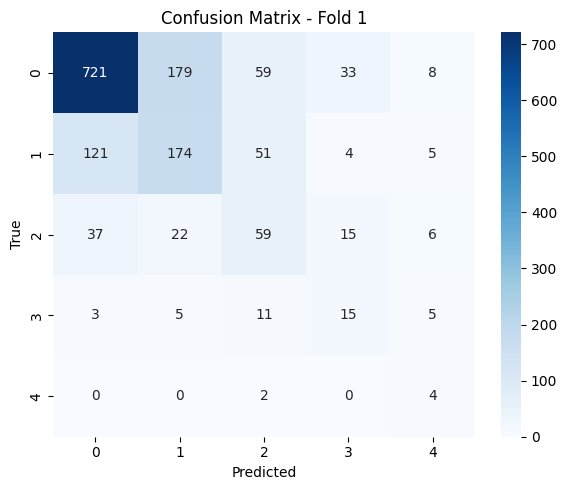

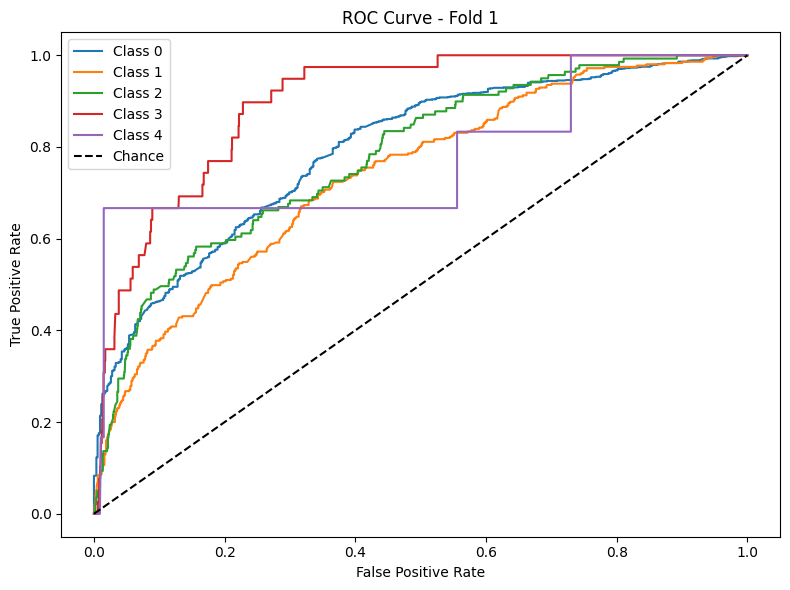

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.6360 - loss: 0.9998 - val_accuracy: 0.5075 - val_loss: 1.0637
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7195 - loss: 0.7459 - val_accuracy: 0.5569 - val_loss: 1.0112
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7404 - loss: 0.6945 - val_accuracy: 0.5965 - val_loss: 0.9612
Epoch 4/30
553/553 - 2s - 4ms/step - accuracy: 0.7485 - loss: 0.6640 - val_accuracy: 0.5991 - val_loss: 0.9377
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7564 - loss: 0.6423 - val_accuracy: 0.5991 - val_loss: 0.9697
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7603 - loss: 0.6330 - val_accuracy: 0.6062 - val_loss: 0.9063
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7662 - loss: 0.6146 - val_accuracy: 0.5750 - val_loss: 0.9585
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7677 - loss: 0.6054 - val_accuracy: 0.5939 - val_loss: 0.9257
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7723 - loss: 0.5996 - val_accuracy: 0.6049 - val_loss: 0.9092
Epoch 10/30


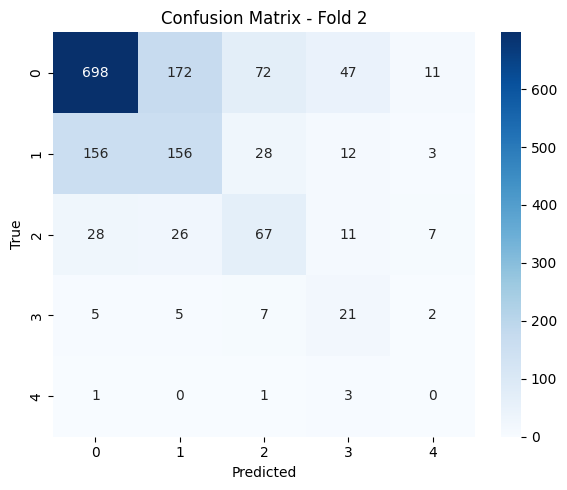

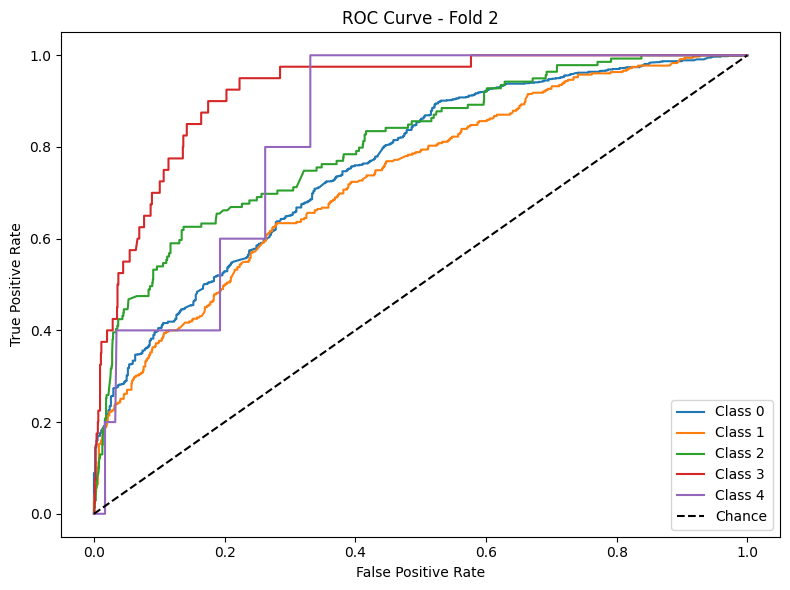

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 6s - 10ms/step - accuracy: 0.6311 - loss: 0.9891 - val_accuracy: 0.5276 - val_loss: 1.0677
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7153 - loss: 0.7353 - val_accuracy: 0.5666 - val_loss: 1.0168
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7260 - loss: 0.6903 - val_accuracy: 0.5874 - val_loss: 0.9516
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7422 - loss: 0.6591 - val_accuracy: 0.6290 - val_loss: 0.9498
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7473 - loss: 0.6453 - val_accuracy: 0.6056 - val_loss: 0.9455
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7573 - loss: 0.6294 - val_accuracy: 0.6225 - val_loss: 0.9175
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7612 - loss: 0.6151 - val_accuracy: 0.6225 - val_loss: 0.9024
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7633 - loss: 0.6082 - val_accuracy: 0.6010 - val_loss: 0.9110
Epoch 9/30
553/553 - 2s - 3ms/step - accuracy: 0.7680 - loss: 0.5987 - val_accuracy: 0.6225 - val_loss: 0.9024
Epoch 10/30

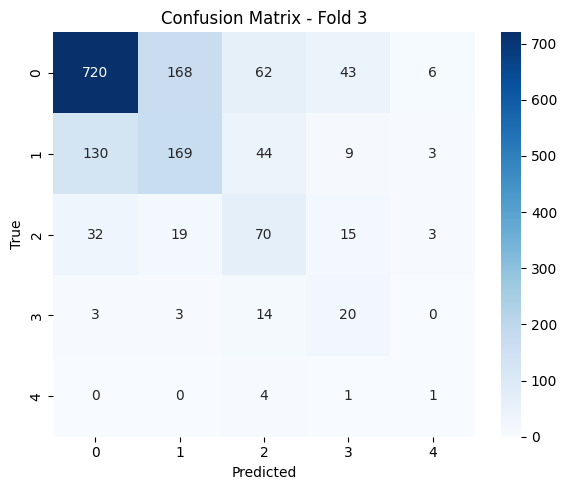

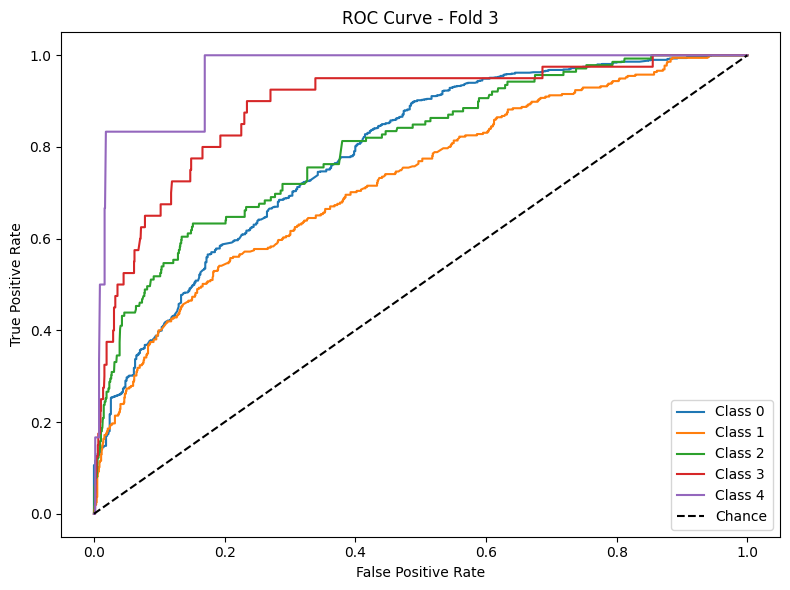

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


553/553 - 5s - 9ms/step - accuracy: 0.6320 - loss: 0.9957 - val_accuracy: 0.5533 - val_loss: 1.0665
Epoch 2/30
553/553 - 2s - 3ms/step - accuracy: 0.7196 - loss: 0.7492 - val_accuracy: 0.5572 - val_loss: 0.9840
Epoch 3/30
553/553 - 2s - 3ms/step - accuracy: 0.7309 - loss: 0.7024 - val_accuracy: 0.5722 - val_loss: 0.9567
Epoch 4/30
553/553 - 2s - 3ms/step - accuracy: 0.7381 - loss: 0.6772 - val_accuracy: 0.6190 - val_loss: 0.9390
Epoch 5/30
553/553 - 2s - 3ms/step - accuracy: 0.7481 - loss: 0.6544 - val_accuracy: 0.6060 - val_loss: 0.9419
Epoch 6/30
553/553 - 2s - 3ms/step - accuracy: 0.7529 - loss: 0.6380 - val_accuracy: 0.6118 - val_loss: 0.9225
Epoch 7/30
553/553 - 2s - 3ms/step - accuracy: 0.7591 - loss: 0.6253 - val_accuracy: 0.5949 - val_loss: 0.9412
Epoch 8/30
553/553 - 2s - 3ms/step - accuracy: 0.7599 - loss: 0.6209 - val_accuracy: 0.6248 - val_loss: 0.9038
Epoch 9/30
553/553 - 2s - 4ms/step - accuracy: 0.7632 - loss: 0.6153 - val_accuracy: 0.6209 - val_loss: 0.9032
Epoch 10/30


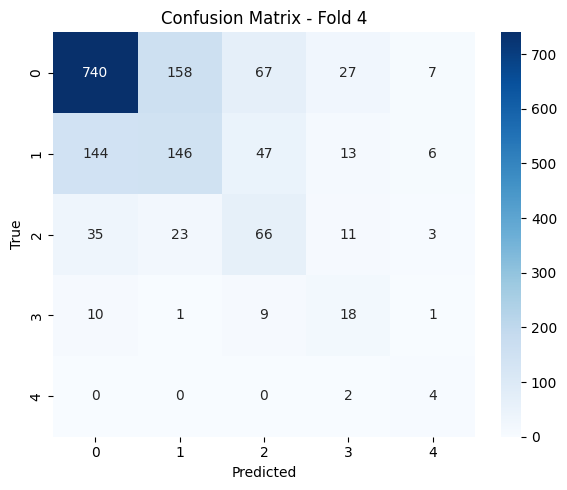

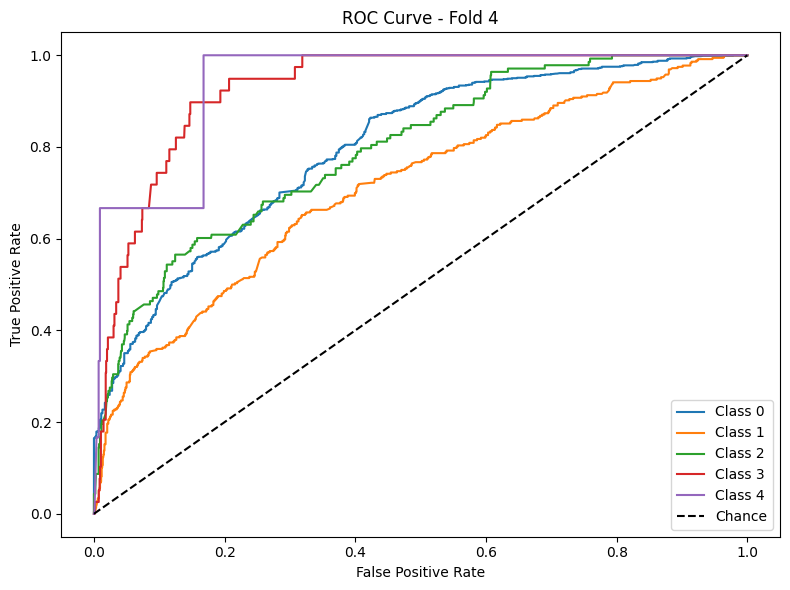

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 - 5s - 10ms/step - accuracy: 0.5991 - loss: 1.0598 - val_accuracy: 0.5579 - val_loss: 1.0060
Epoch 2/30
500/500 - 2s - 3ms/step - accuracy: 0.6831 - loss: 0.8116 - val_accuracy: 0.5793 - val_loss: 0.9588
Epoch 3/30
500/500 - 2s - 3ms/step - accuracy: 0.6998 - loss: 0.7513 - val_accuracy: 0.5858 - val_loss: 0.9575
Epoch 4/30
500/500 - 2s - 3ms/step - accuracy: 0.7154 - loss: 0.7178 - val_accuracy: 0.5865 - val_loss: 0.9313
Epoch 5/30
500/500 - 2s - 3ms/step - accuracy: 0.7209 - loss: 0.7040 - val_accuracy: 0.5936 - val_loss: 0.9229
Epoch 6/30
500/500 - 2s - 3ms/step - accuracy: 0.7266 - loss: 0.6892 - val_accuracy: 0.5806 - val_loss: 0.9247
Epoch 7/30
500/500 - 2s - 4ms/step - accuracy: 0.7307 - loss: 0.6779 - val_accuracy: 0.6203 - val_loss: 0.9191
Epoch 8/30
500/500 - 2s - 4ms/step - accuracy: 0.7385 - loss: 0.6625 - val_accuracy: 0.6216 - val_loss: 0.9086
Epoch 9/30
500/500 - 2s - 3ms/step - accuracy: 0.7417 - loss: 0.6568 - val_accuracy: 0.6222 - val_loss: 0.9064
Epoch 10/30

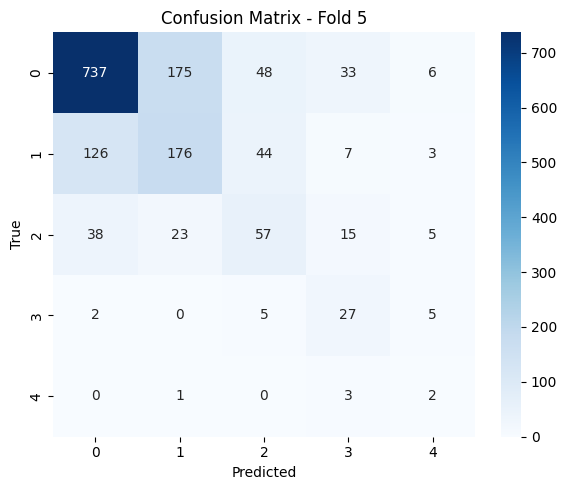

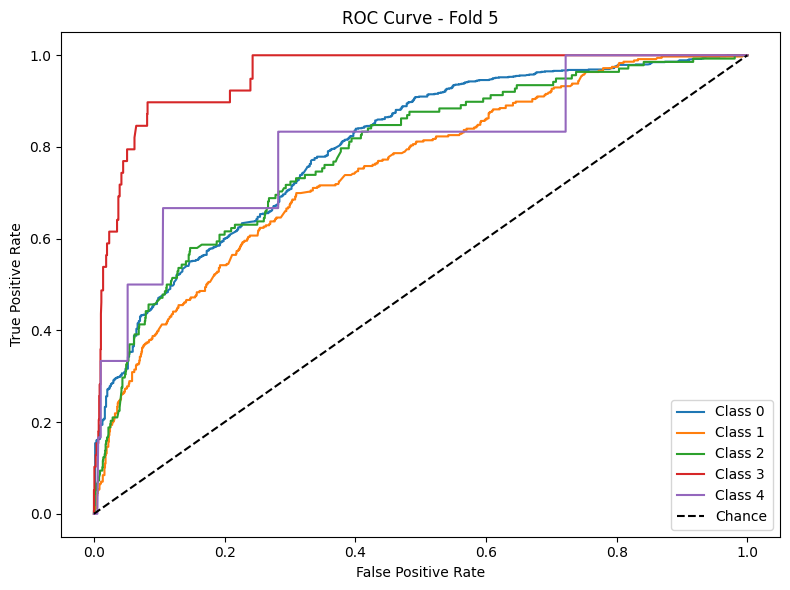


Average Accuracy: 0.6328
Average F1 Macro: 0.4228
Average AUC: 0.8191


In [15]:
phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"

    # Lưu model keras
    model.save(f"best_model_{temp}_phase{i}.h5")

    # Lưu scaler sklearn
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")

    results[f"phase{i}"] = metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       568
           1       0.31      0.40      0.35        63
           2       0.26      0.19      0.22        43
           3       0.08      0.07      0.07        15
           4       0.00      0.00      0.00         9

    accuracy                           0.78       698
   macro avg       0.31      0.31      0.31       698
weighted avg       0.77      0.78      0.78       698



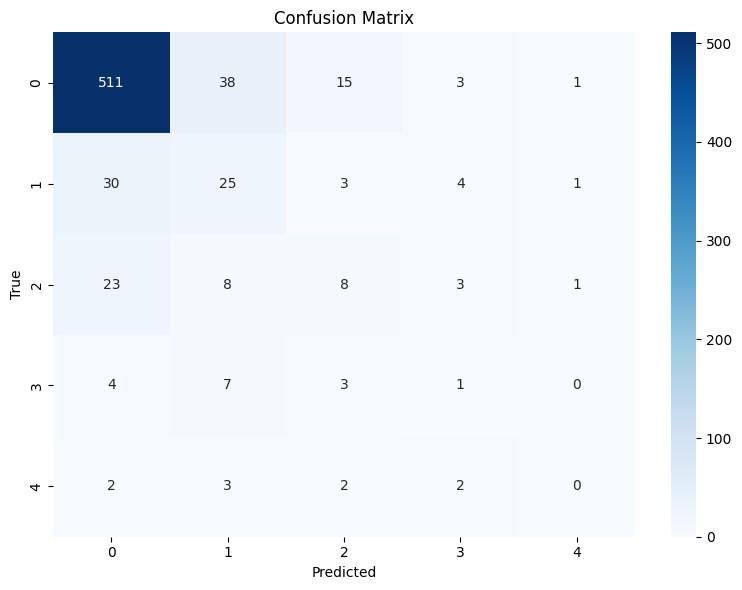


Test AUC (macro-average, OVR): 0.6816


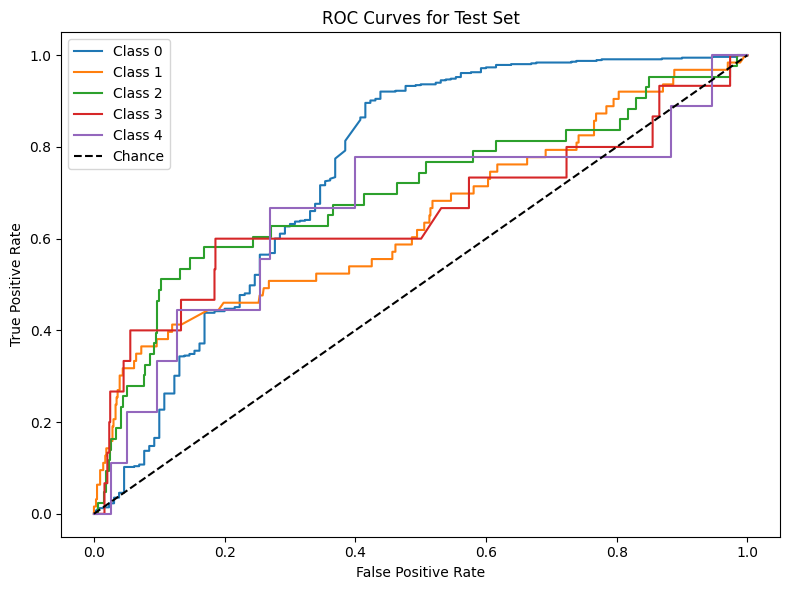

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       544
           1       0.21      0.24      0.22        59
           2       0.28      0.21      0.24        42
           3       0.50      0.07      0.12        14
           4       0.00      0.00      0.00         9

    accuracy                           0.78       668
   macro avg       0.37      0.29      0.30       668
weighted avg       0.77      0.78      0.77       668



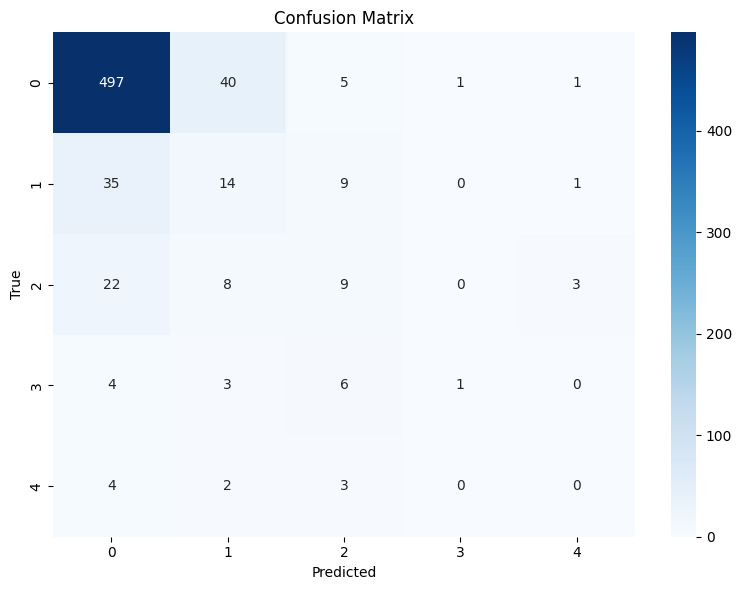


Test AUC (macro-average, OVR): 0.7255


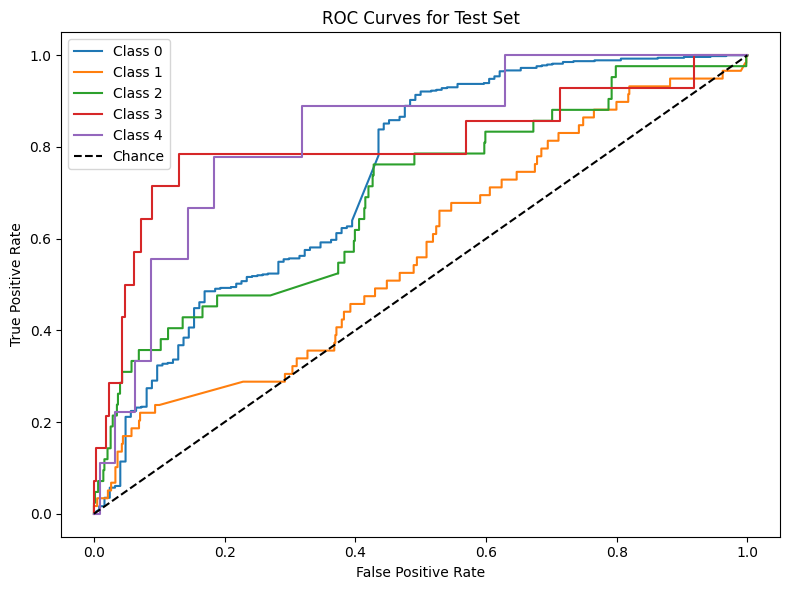

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       455
           1       0.29      0.15      0.20        52
           2       0.30      0.21      0.24        29
           3       0.18      0.30      0.22        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       554
   macro avg       0.33      0.32      0.32       554
weighted avg       0.77      0.81      0.79       554



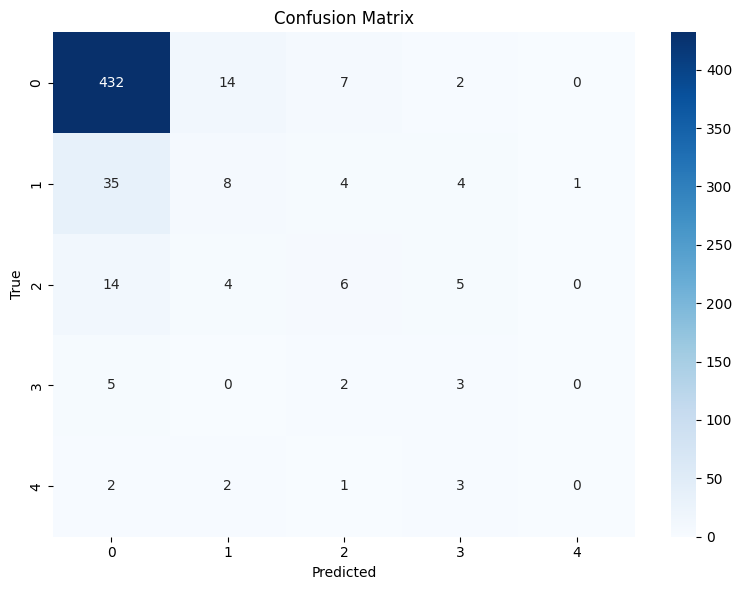


Test AUC (macro-average, OVR): 0.7037


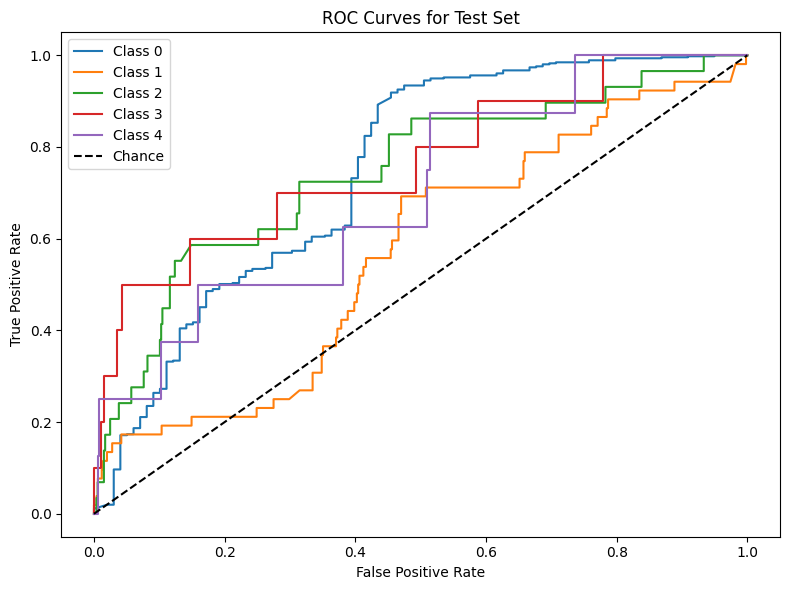

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       395
           1       0.19      0.30      0.24        40
           2       0.24      0.38      0.29        24
           3       0.00      0.00      0.00        10
           4       0.25      0.12      0.17         8

    accuracy                           0.75       477
   macro avg       0.32      0.33      0.31       477
weighted avg       0.78      0.75      0.76       477



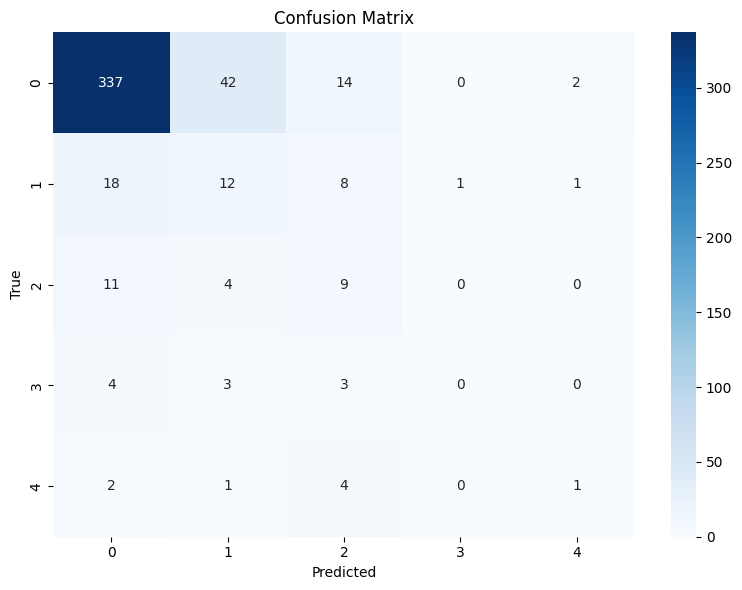


Test AUC (macro-average, OVR): 0.6236


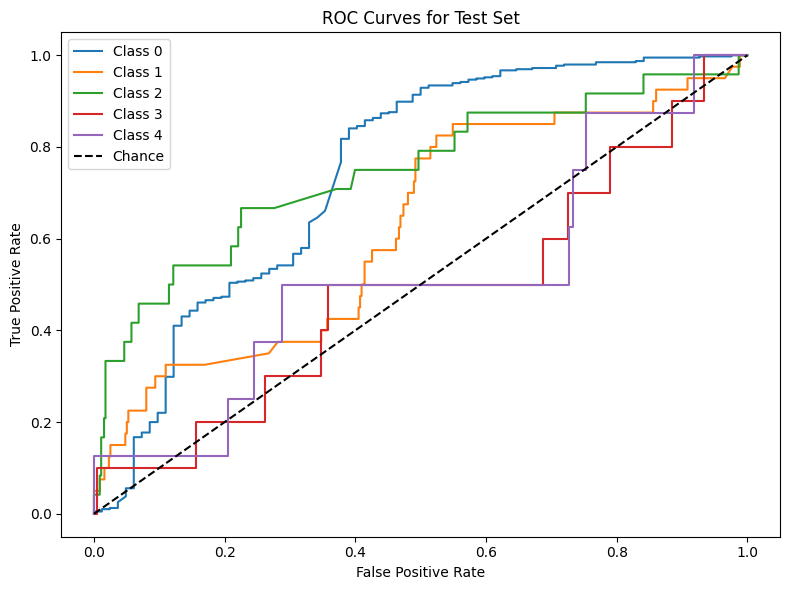

In [16]:
# temp = "sample"  # hoặc "no_sample", tùy cách bạn lưu model

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.h5'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
